In [12]:
import pandas as pd
#from hmmlearn import hmm
import numpy as np
import seaborn as sns
from scipy.stats import norm
import itertools
import matplotlib.pyplot as plt
#from hmmlearn.hmm import GMMHMM
from  sklearn.metrics import mean_squared_error as mse
from sklearn.utils import class_weight
from astropy.io import fits
import matplotlib.pyplot as plt
import os, sys

from sklearn.metrics import confusion_matrix,accuracy_score
from keras.regularizers import l2
from keras.activations import tanh
from keras.models import Sequential
from keras.layers import *
from keras.losses import categorical_crossentropy,binary_crossentropy
from keras.optimizers import SGD
from keras.callbacks import LearningRateScheduler
from keras import optimizers
from keras import backend as K
from time import time
from random import shuffle,seed
from sklearn.metrics import classification_report
from keras.regularizers import l2
from keras.callbacks import LearningRateScheduler
from keras.callbacks import EarlyStopping

import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score,f1_score, confusion_matrix, mean_absolute_error,mean_squared_error, median_absolute_error
from sklearn.preprocessing import normalize
import time
import matplotlib.pyplot as plt

def plot_df(df):
    try:
        from IPython.display import display
        display(df)
    except:
        print(df)
    
def plot_confusion_matrix(cm, target_names, title='Confusion matrix (f1-score)',cmap=None, normalize=True):
    import itertools
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0.0, vmax=1.0)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    
def calculate_metrics(y_true,y_pred,plot=True, title=""):
    dic_return = {}
    dic_return["Precision raw"] = precision_score(y_true,y_pred,average=None,labels=[0,1])
    dic_return["Recall raw"] = recall_score(y_true,y_pred,average=None,labels=[0,1])
    #dic_return["Precision"] = precision_score(y_true,y_pred,average=None,labels=[0,1])
    #dic_return["Recall"] = recall_score(y_true,y_pred,average=None,labels=[0,1])
    dic_return["F1 raw"] = f1_score(y_true,y_pred,average=None,labels=[0,1])
    dic_return["F1 weighted"] = f1_score(y_true,y_pred,average="weighted",labels=[0,1])
    dic_return["F1 macro"] = f1_score(y_true,y_pred,average="macro",labels=[0,1])
    dic_return["F1 micro"] = f1_score(y_true,y_pred,average="micro",labels=[0,1])
    matriz=confusion_matrix(y_true,y_pred, labels=[0,1])
    if plot:
        df = pd.DataFrame(dic_return)
        df.index = ["False Positive","Confirmed"]
        plot_df(df)
        plot_confusion_matrix(normalize(matriz,axis=1,norm='l1'),["False Positive","Confirmed"],title)
    dic_return["Confusion Matrix"] = matriz
    return dic_return


def calculate_median_abs_err(real, pred): 
    if len(real.shape) > 1:
        return np.mean([median_absolute_error(real[:,d],pred[:,d]) for d in range(real.shape[1])])   
    else:
        return median_absolute_error(real,pred)
    
def calculate_mean_abs_perce_err(real, pred):
    diff = np.abs((real - pred) / np.clip(np.abs(real), 1e-7, None))
    return 100. * np.mean(diff) #sin *100 es "fractional"

def calculate_Rmean_squar_log_err(real, pred):
    first_log = np.log(np.clip(pred, 1e-7, None) + 1.)
    second_log = np.log(np.clip(real, 1e-7, None) + 1.)
    return np.sqrt(np.mean(np.square(first_log - second_log)))

def evaluate_metadata(real, pred, plot=False):
    dic_res = {}
    dic_res["MSE"] = mean_squared_error(real, pred)
    dic_res["MAE"] = mean_absolute_error(real, pred)
    dic_res["MeAE"] = calculate_median_abs_err(real, pred)
    dic_res["MApE"] = calculate_mean_abs_perce_err(real,pred)
    dic_res["RMSLE"] = calculate_Rmean_squar_log_err(real,pred)
    if plot:
        df = pd.DataFrame(dic_res)
        df.index = ["Real"]
        plot_df(df)
    return dic_res

def evaluate_metadata_raw(real, pred, plot=True, metadata_used=[""]):
    mse_raw = []
    mae_raw = []
    mEae_raw = []
    maPe_raw = []
    rmsle_raw = []
    for d in range(real.shape[1]):        
        dic_aux = evaluate_metadata(real[:,d], pred[:,d], plot=False)
        mse_raw.append(dic_aux["MSE"])
        mae_raw.append(dic_aux["MAE"])
        mEae_raw.append(dic_aux["MeAE"])
        maPe_raw.append(dic_aux["MApE"])
        rmsle_raw.append(dic_aux["RMSLE"])
        
    res_metadata = {}
    res_metadata["MSE"] = mse_raw
    res_metadata["MAE"] = mae_raw
    res_metadata["MeAE"] = mEae_raw
    res_metadata["MApE"] = maPe_raw
    res_metadata["RMSLE"] = rmsle_raw
    
    if plot:
        df = pd.DataFrame(res_metadata)
        df.index = metadata_used
        df.loc["Global"] = np.mean(df, axis=0)
        plot_df(df.transpose())
    res_metadata["MSE"].append(np.mean(mse_raw))
    res_metadata["MAE"].append(np.mean(mae_raw))
    res_metadata["MeAE"].append(np.mean(mEae_raw))
    res_metadata["MApE"].append(np.mean(maPe_raw))
    res_metadata["RMSLE"].append(np.mean(rmsle_raw))
    return res_metadata




def train_model(aux_model, x_train, y_train, x_val, y_val, e=25, BS=128):
    hist=aux_model.fit(x_train, y_train, batch_size=BS, epochs=e, verbose=1, validation_data=(x_val,y_val))
    plt.plot(hist.history['loss'],label="train_loss")
    plt.plot(hist.history['val_loss'],label="val_loss")
    plt.title("Model Loss BCE CNN") 
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(loc="upper right")
    plt.show()

    plt.plot(hist.history['acc'],label="Train accuracy" )
    plt.plot(hist.history['val_acc'],label="Val accuracy" )
    plt.title("Model Accuracy BCE CNN") 
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(loc="upper right")
    plt.show()

    predichos=aux_model.predict_classes(x_val)
    calculate_metrics(y_val, predichos,'[VAL] Confusion Matrix 50 epochs CNN + reverse LC')


    import keras
from keras.callbacks import Callback,ModelCheckpoint, ReduceLROnPlateau
class Metrics(Callback):
    def on_train_begin(self, logs={}):
        self.val_f1s = []

    def on_epoch_end(self, batch, logs={}):
        predict = np.squeeze(self.model.predict_classes(self.validation_data[0]))
        targ = np.squeeze(self.validation_data[1])
        f1s = f1_score(targ, predict, average='macro')
        self.val_f1s.append(f1s)
        print(" - val_f1: %f " %(f1s))
        return

import tensorflow as tf
def binary_focal_loss(gamma=2., alpha=.25):
    """
    Binary form of focal loss.
      FL(p_t) = -alpha * (1 - p_t)**gamma * log(p_t)
      where p = sigmoid(x), p_t = p or 1 - p depending on if the label is 1 or 0, respectively.
    References:
        https://arxiv.org/pdf/1708.02002.pdf
    Usage:
     model.compile(loss=[binary_focal_loss(alpha=.25, gamma=2)], metrics=["accuracy"], optimizer=adam)
    """
    def binary_focal_loss_fixed(y_true, y_pred):
        """
        :param y_true: A tensor of the same shape as `y_pred`
        :param y_pred:  A tensor resulting from a sigmoid
        :return: Output tensor.
        """
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))

        epsilon = K.epsilon()
        # clip to prevent NaN's and Inf's
        pt_1 = K.clip(pt_1, epsilon, 1. - epsilon)
        pt_0 = K.clip(pt_0, epsilon, 1. - epsilon)

        return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) \
               -K.sum((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))

    return binary_focal_loss_fixed

def train_model(aux_model, x_train, y_train, x_val, y_val, e=25, BS=128, focal=False,alpha=0.6,gamma = 2,save_f='best_mod.hdf5'):
    if focal:
        aux_model.compile(loss=binary_focal_loss(alpha=alpha, gamma=gamma),optimizer='Adam',metrics=['accuracy'])
    else:
        aux_model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])
    
    calls = []
    metrics = Metrics()
    calls.append(metrics)
    mcp_save = ModelCheckpoint(save_f, save_best_only=True, monitor='val_loss', mode='min')
    calls.append(mcp_save)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', mode ='min',factor=0.2,patience=10, min_lr=0.001)
    if not focal:
        calls.append(reduce_lr)
    hist=aux_model.fit(x_train, y_train, batch_size=BS, epochs=e, verbose=1, validation_split=0.1,#validation_data=(x_val,y_val),
                      callbacks=calls)
    
    plt.figure(figsize=(12,5))
    plt.plot(hist.history['loss'],label="train_loss")
    plt.plot(hist.history['val_loss'],label="val_loss")
    plt.title("Model Loss BCE CNN") 
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(loc="upper right")
    plt.show()

    plt.figure(figsize=(12,5))
    plt.plot(hist.history['acc'],label="Train accuracy" )
    plt.plot(hist.history['val_acc'],label="Val accuracy" )
    plt.title("Model Accuracy BCE CNN") 
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(loc="upper right")
    plt.show()
    
    plt.figure(figsize=(12,5))
    if not focal:
        plt.plot(hist.history['val_loss'],label="loss" )
    plt.plot(hist.history['val_acc'],label="accuracy" )
    plt.plot(metrics.val_f1s,label="F1" )
    plt.ylabel("Metric")
    plt.xlabel('Epochs')
    plt.title("Test set/val")
    plt.legend(loc="upper left")
    plt.show()
    
    
    #print("Best f1 macro trough iters %f on %d "%(np.max(metrics.val_f1s),np.argmax(metrics.val_f1s)))

    #predichos=aux_model.predict_classes(x_val)
    #calculate_metrics(y_val, predichos,'[VAL] Confusion Matrix 50 epochs CNN + reverse LC')

In [13]:
df_aux = pd.read_csv("../../KOI_Data/kepler_dataset.csv")
labels = (df_aux["NExScI Disposition"] == "CONFIRMED").values*1

fold = "../../KOI_Data/"
df_sets = pd.read_csv(fold+"/koi_sets.csv") 
mask_train = (df_sets["Set"] == "Train").values
mask_test = (df_sets["Set"] == "Test").values
mask_unlabeled = (df_sets["Set"] == "Unlabeled").values
df_meta = pd.read_csv(fold+"/koi_metadata.csv")
df_meta_train = df_meta[mask_train]
df_meta_test = df_meta[mask_test]
df_meta_unb = df_meta[mask_unlabeled]

y_train= (df_meta_train['NExScI Disposition'].values=="CONFIRMED")*1
y_val = (df_meta_test['NExScI Disposition'].values=="CONFIRMED")*1

y_train = np.tile(y_train, (2))

unique_train, counts_train = np.unique(y_train, return_counts=True)
unique_val, counts_val = np.unique(y_val, return_counts=True)

print('y_train distribution: 0:%i   1:%i'%(counts_train[0],counts_train[1]))
print('y_val distribution:   0:%i   1:%i'%(counts_val[0],counts_val[1]))

y_train distribution: 0:5458   1:3220
y_val distribution:   0:1247   1:671


In [23]:
import keras 
def execute_main(n_up,n_down):
    channel_1 = np.load(folder+'/normal/MTF_u%d_d%d.npy'%(n_up,n_down))  
    channel_2 = np.load(folder+'/invertidos/MTF_u%d_d%d.npy'%(n_up,n_down))  
    channel_3 = np.load(folder+'/time/MTF_time_u%d_d%d.npy'%(n_up,n_down))  

    x_all = []
    for i in range(channel_1.shape[0]):
        combined_image = np.dstack((channel_1[i],channel_3[i]))
        x_all.append(combined_image)
    x_all = np.asarray(x_all)

    x_all2 = []
    for i in range(channel_1.shape[0]):
        combined_image = np.dstack((channel_2[i],channel_3[i]))
        x_all2.append(combined_image)
    x_all2 = np.asarray(x_all2)

    x_train1 = x_all[mask_train]
    x_train2 = x_all2[mask_train]
    x_train = np.concatenate([x_train1,x_train2]) #concat

    x_val = x_all[mask_test]


    print ("Objetos de entrenamiento:",x_train.shape, y_train.shape)
    print ("Objetos de validación:",x_val.shape,y_val.shape)

    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:], strides=(1, 1),activation="relu", padding="valid"))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(32, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.25))

    model.add(Flatten())

    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(1, activation='sigmoid'))
    model.summary()
    
    train_model(model, x_train, y_train, x_val, y_val, e=200, BS=128*2)  #save model

    model = keras.models.load_model("best_mod.hdf5")

    predichos=model.predict_classes(x_val)
    calculate_metrics(y_val, predichos,'[VAL] Confusion Matrix 50 epochs CNN + reverse LC') #con 3 capas aumentando/double

In [15]:
folder = "/media/fmena/Respaldo/KOI_LC/MTF/"


In [24]:
n_up = 5
n_down = 10

Objetos de entrenamiento: (8678, 15, 15, 2) (8678,)
Objetos de validación: (1918, 15, 15, 2) (1918,)
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 13, 13, 32)        608       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 6, 6, 32)          0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 4, 4, 32)          9248      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 2, 2, 32)          0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 2, 2, 32)          0         
___________________

7810/7810 [==============================] - 0s 22us/step - loss: 0.4939 - acc: 0.7023 - val_loss: 0.5150 - val_acc: 0.6797
 - val_f1: 0.655538 
Epoch 42/200
7810/7810 [==============================] - 0s 23us/step - loss: 0.4956 - acc: 0.7074 - val_loss: 0.5162 - val_acc: 0.6832
 - val_f1: 0.658578 
Epoch 43/200
7810/7810 [==============================] - 0s 24us/step - loss: 0.4932 - acc: 0.7082 - val_loss: 0.5073 - val_acc: 0.6809
 - val_f1: 0.677329 
Epoch 44/200
7810/7810 [==============================] - 0s 23us/step - loss: 0.4883 - acc: 0.7097 - val_loss: 0.5142 - val_acc: 0.6740
 - val_f1: 0.650027 
Epoch 45/200
7810/7810 [==============================] - 0s 23us/step - loss: 0.4888 - acc: 0.7079 - val_loss: 0.5115 - val_acc: 0.6751
 - val_f1: 0.654505 
Epoch 46/200
7810/7810 [==============================] - 0s 24us/step - loss: 0.4888 - acc: 0.7085 - val_loss: 0.5055 - val_acc: 0.6924
 - val_f1: 0.682797 
Epoch 47/200
7810/7810 [==============================] - 0s 24us

7810/7810 [==============================] - 0s 22us/step - loss: 0.4658 - acc: 0.7247 - val_loss: 0.4744 - val_acc: 0.7085
 - val_f1: 0.706091 
Epoch 94/200
7810/7810 [==============================] - 0s 23us/step - loss: 0.4608 - acc: 0.7361 - val_loss: 0.4828 - val_acc: 0.7097
 - val_f1: 0.699987 
Epoch 95/200
7810/7810 [==============================] - 0s 23us/step - loss: 0.4588 - acc: 0.7347 - val_loss: 0.4796 - val_acc: 0.7028
 - val_f1: 0.694353 
Epoch 96/200
7810/7810 [==============================] - 0s 22us/step - loss: 0.4615 - acc: 0.7351 - val_loss: 0.4837 - val_acc: 0.7005
 - val_f1: 0.689372 
Epoch 97/200
7810/7810 [==============================] - 0s 22us/step - loss: 0.4585 - acc: 0.7335 - val_loss: 0.4796 - val_acc: 0.6959
 - val_f1: 0.684015 
Epoch 98/200
7810/7810 [==============================] - 0s 26us/step - loss: 0.4586 - acc: 0.7364 - val_loss: 0.4818 - val_acc: 0.6832
 - val_f1: 0.670387 
Epoch 99/200
7810/7810 [==============================] - 0s 23us

 - val_f1: 0.696091 
Epoch 145/200
7810/7810 [==============================] - 0s 23us/step - loss: 0.4453 - acc: 0.7466 - val_loss: 0.4796 - val_acc: 0.7016
 - val_f1: 0.680119 
Epoch 146/200
7810/7810 [==============================] - 0s 22us/step - loss: 0.4433 - acc: 0.7478 - val_loss: 0.4701 - val_acc: 0.7074
 - val_f1: 0.701476 
Epoch 147/200
7810/7810 [==============================] - 0s 23us/step - loss: 0.4403 - acc: 0.7502 - val_loss: 0.4797 - val_acc: 0.7120
 - val_f1: 0.700772 
Epoch 148/200
7810/7810 [==============================] - 0s 23us/step - loss: 0.4391 - acc: 0.7498 - val_loss: 0.4712 - val_acc: 0.7143
 - val_f1: 0.712624 
Epoch 149/200
7810/7810 [==============================] - 0s 24us/step - loss: 0.4445 - acc: 0.7449 - val_loss: 0.4801 - val_acc: 0.6832
 - val_f1: 0.660358 
Epoch 150/200
7810/7810 [==============================] - 0s 23us/step - loss: 0.4451 - acc: 0.7458 - val_loss: 0.4719 - val_acc: 0.6970
 - val_f1: 0.681587 
Epoch 151/200
7810/7810 [

7810/7810 [==============================] - 0s 22us/step - loss: 0.4287 - acc: 0.7592 - val_loss: 0.4697 - val_acc: 0.7154
 - val_f1: 0.705299 
Epoch 197/200
7810/7810 [==============================] - 0s 22us/step - loss: 0.4300 - acc: 0.7540 - val_loss: 0.4678 - val_acc: 0.7131
 - val_f1: 0.700392 
Epoch 198/200
7810/7810 [==============================] - 0s 23us/step - loss: 0.4249 - acc: 0.7609 - val_loss: 0.4727 - val_acc: 0.7189
 - val_f1: 0.707681 
Epoch 199/200
7810/7810 [==============================] - 0s 22us/step - loss: 0.4330 - acc: 0.7539 - val_loss: 0.4734 - val_acc: 0.6959
 - val_f1: 0.679511 
Epoch 200/200
7810/7810 [==============================] - 0s 22us/step - loss: 0.4224 - acc: 0.7663 - val_loss: 0.4691 - val_acc: 0.7108
 - val_f1: 0.694787 


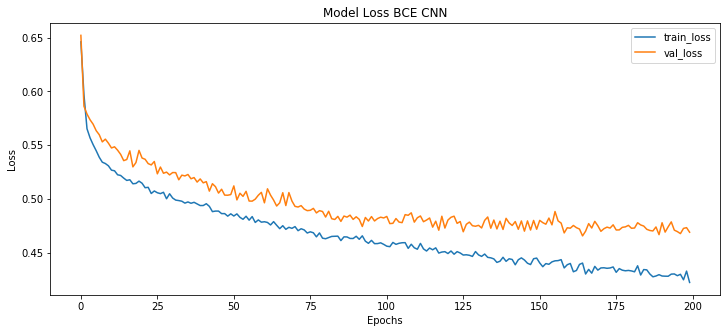

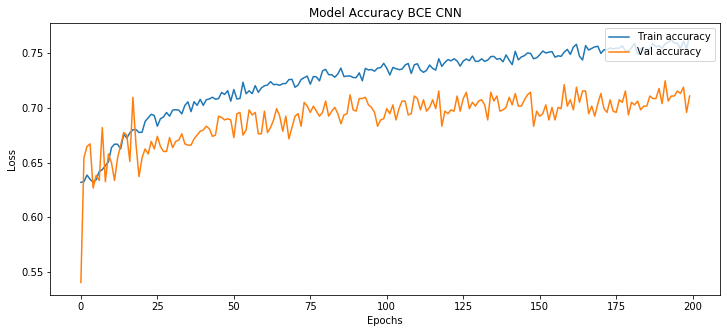

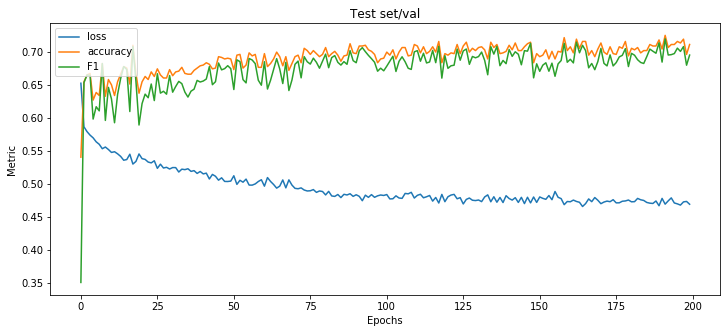

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.803200,0.805132,0.804165,0.744914,0.719484,0.745047
Confirmed,0.636228,0.633383,0.634802,0.744914,0.719484,0.745047


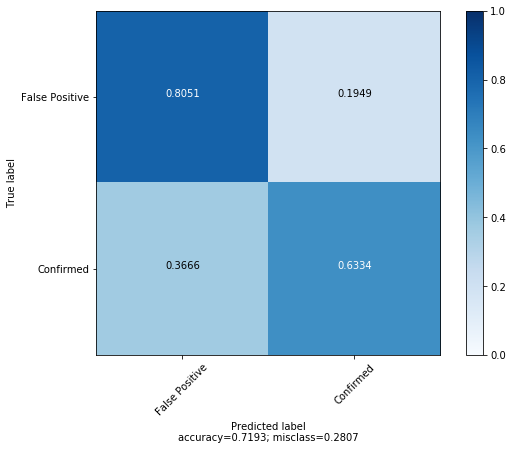

In [26]:
execute_main(n_up,n_down)

In [45]:
n_up = 5
n_down = 15

Objetos de entrenamiento: (8678, 20, 20, 2) (8678,)
Objetos de validación: (1918, 20, 20, 2) (1918,)
Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_29 (Conv2D)           (None, 18, 18, 32)        608       
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 9, 9, 32)          0         
_________________________________________________________________
dropout_43 (Dropout)         (None, 9, 9, 32)          0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 7, 7, 32)          9248      
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 3, 3, 32)          0         
_________________________________________________________________
dropout_44 (Dropout)         (None, 3, 3, 32)          0         
__________________

7810/7810 [==============================] - 0s 29us/step - loss: 0.4938 - acc: 0.6987 - val_loss: 0.5052 - val_acc: 0.6820
 - val_f1: 0.674265 
Epoch 42/200
7810/7810 [==============================] - 0s 30us/step - loss: 0.4948 - acc: 0.7028 - val_loss: 0.5105 - val_acc: 0.6694
 - val_f1: 0.642719 
Epoch 43/200
7810/7810 [==============================] - 0s 31us/step - loss: 0.4973 - acc: 0.6959 - val_loss: 0.5068 - val_acc: 0.6797
 - val_f1: 0.665991 
Epoch 44/200
7810/7810 [==============================] - 0s 31us/step - loss: 0.4928 - acc: 0.7058 - val_loss: 0.5059 - val_acc: 0.6924
 - val_f1: 0.678088 
Epoch 45/200
7810/7810 [==============================] - 0s 29us/step - loss: 0.4934 - acc: 0.6978 - val_loss: 0.5029 - val_acc: 0.6809
 - val_f1: 0.670916 
Epoch 46/200
7810/7810 [==============================] - 0s 30us/step - loss: 0.4940 - acc: 0.7027 - val_loss: 0.5118 - val_acc: 0.6613
 - val_f1: 0.630114 
Epoch 47/200
7810/7810 [==============================] - 0s 29us

7810/7810 [==============================] - 0s 30us/step - loss: 0.4661 - acc: 0.7300 - val_loss: 0.4850 - val_acc: 0.6889
 - val_f1: 0.675603 
Epoch 94/200
7810/7810 [==============================] - 0s 30us/step - loss: 0.4633 - acc: 0.7257 - val_loss: 0.4831 - val_acc: 0.6993
 - val_f1: 0.689925 
Epoch 95/200
7810/7810 [==============================] - 0s 29us/step - loss: 0.4684 - acc: 0.7256 - val_loss: 0.4878 - val_acc: 0.6843
 - val_f1: 0.660937 
Epoch 96/200
7810/7810 [==============================] - 0s 29us/step - loss: 0.4647 - acc: 0.7283 - val_loss: 0.4860 - val_acc: 0.6866
 - val_f1: 0.665950 
Epoch 97/200
7810/7810 [==============================] - 0s 29us/step - loss: 0.4643 - acc: 0.7291 - val_loss: 0.4826 - val_acc: 0.6924
 - val_f1: 0.683815 
Epoch 98/200
7810/7810 [==============================] - 0s 30us/step - loss: 0.4665 - acc: 0.7254 - val_loss: 0.4929 - val_acc: 0.6786
 - val_f1: 0.642125 
Epoch 99/200
7810/7810 [==============================] - 0s 30us

 - val_f1: 0.696798 
Epoch 145/200
7810/7810 [==============================] - 0s 30us/step - loss: 0.4488 - acc: 0.7411 - val_loss: 0.4800 - val_acc: 0.6855
 - val_f1: 0.661510 
Epoch 146/200
7810/7810 [==============================] - 0s 30us/step - loss: 0.4479 - acc: 0.7421 - val_loss: 0.4800 - val_acc: 0.6959
 - val_f1: 0.678070 
Epoch 147/200
7810/7810 [==============================] - 0s 30us/step - loss: 0.4439 - acc: 0.7435 - val_loss: 0.4729 - val_acc: 0.7062
 - val_f1: 0.694068 
Epoch 148/200
7810/7810 [==============================] - 0s 30us/step - loss: 0.4451 - acc: 0.7438 - val_loss: 0.4805 - val_acc: 0.6912
 - val_f1: 0.668791 
Epoch 149/200
7810/7810 [==============================] - 0s 29us/step - loss: 0.4458 - acc: 0.7451 - val_loss: 0.4801 - val_acc: 0.7028
 - val_f1: 0.689717 
Epoch 150/200
7810/7810 [==============================] - 0s 29us/step - loss: 0.4473 - acc: 0.7447 - val_loss: 0.4782 - val_acc: 0.6959
 - val_f1: 0.682185 
Epoch 151/200
7810/7810 [

7810/7810 [==============================] - 0s 29us/step - loss: 0.4306 - acc: 0.7575 - val_loss: 0.4695 - val_acc: 0.7039
 - val_f1: 0.687838 
Epoch 197/200
7810/7810 [==============================] - 0s 30us/step - loss: 0.4301 - acc: 0.7551 - val_loss: 0.4716 - val_acc: 0.7131
 - val_f1: 0.703174 
Epoch 198/200
7810/7810 [==============================] - 0s 29us/step - loss: 0.4299 - acc: 0.7529 - val_loss: 0.4721 - val_acc: 0.7051
 - val_f1: 0.686360 
Epoch 199/200
7810/7810 [==============================] - 0s 30us/step - loss: 0.4299 - acc: 0.7567 - val_loss: 0.4733 - val_acc: 0.7016
 - val_f1: 0.683620 
Epoch 200/200
7810/7810 [==============================] - 0s 29us/step - loss: 0.4319 - acc: 0.7517 - val_loss: 0.4674 - val_acc: 0.7166
 - val_f1: 0.710685 


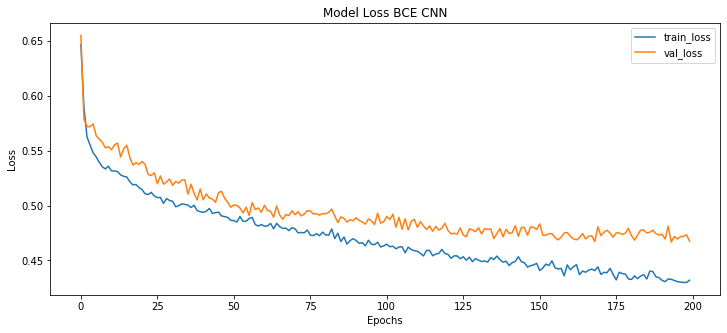

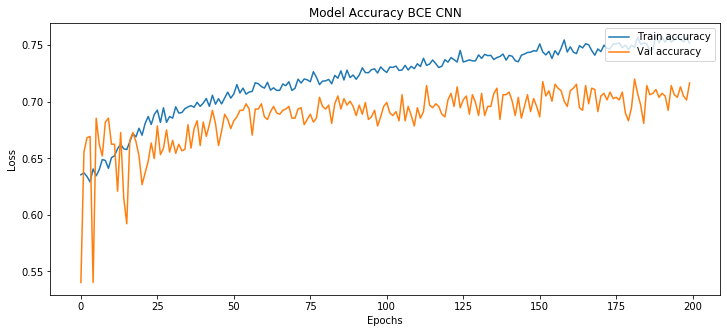

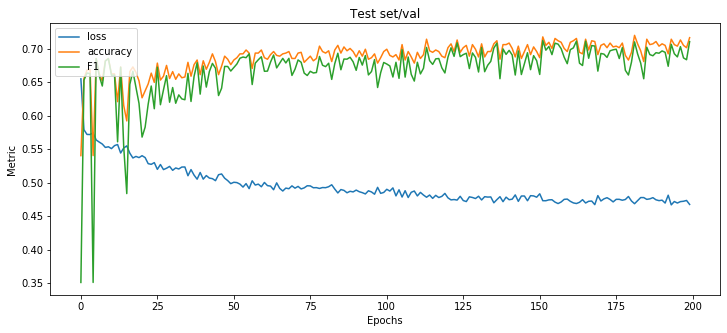

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.805534,0.817161,0.811306,0.752073,0.72665,0.752868
Confirmed,0.650842,0.633383,0.641994,0.752073,0.72665,0.752868


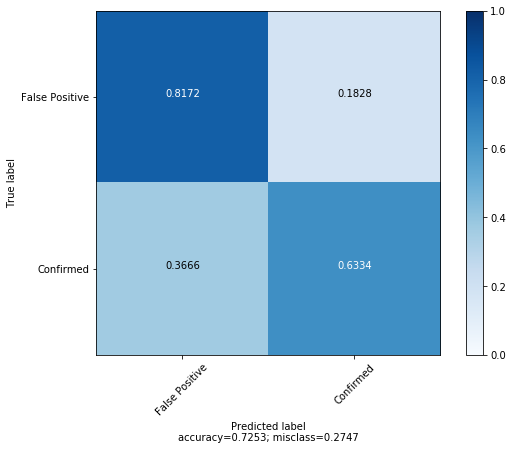

In [46]:
execute_main(n_up,n_down)

In [27]:
n_up = 5
n_down = 30

Objetos de entrenamiento: (8678, 35, 35, 2) (8678,)
Objetos de validación: (1918, 35, 35, 2) (1918,)
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 33, 33, 32)        608       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 7, 7, 32)          0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 7, 7, 32)          0         
___________________

7810/7810 [==============================] - 0s 52us/step - loss: 0.4953 - acc: 0.6971 - val_loss: 0.5146 - val_acc: 0.6763
 - val_f1: 0.669411 
Epoch 42/200
7810/7810 [==============================] - 0s 53us/step - loss: 0.4958 - acc: 0.6950 - val_loss: 0.5245 - val_acc: 0.6394
 - val_f1: 0.602949 
Epoch 43/200
7810/7810 [==============================] - 0s 52us/step - loss: 0.4979 - acc: 0.6917 - val_loss: 0.5230 - val_acc: 0.6452
 - val_f1: 0.615788 
Epoch 44/200
7810/7810 [==============================] - 0s 53us/step - loss: 0.4962 - acc: 0.6964 - val_loss: 0.5270 - val_acc: 0.6382
 - val_f1: 0.602592 
Epoch 45/200
7810/7810 [==============================] - 0s 52us/step - loss: 0.4976 - acc: 0.6914 - val_loss: 0.5207 - val_acc: 0.6498
 - val_f1: 0.626650 
Epoch 46/200
7810/7810 [==============================] - 0s 53us/step - loss: 0.4966 - acc: 0.6927 - val_loss: 0.5271 - val_acc: 0.6348
 - val_f1: 0.599700 
Epoch 47/200
7810/7810 [==============================] - 0s 52us

7810/7810 [==============================] - 0s 55us/step - loss: 0.4697 - acc: 0.7159 - val_loss: 0.4807 - val_acc: 0.7120
 - val_f1: 0.710863 
Epoch 94/200
7810/7810 [==============================] - 0s 54us/step - loss: 0.4664 - acc: 0.7259 - val_loss: 0.4905 - val_acc: 0.6959
 - val_f1: 0.688198 
Epoch 95/200
7810/7810 [==============================] - 0s 54us/step - loss: 0.4651 - acc: 0.7251 - val_loss: 0.4849 - val_acc: 0.7074
 - val_f1: 0.700659 
Epoch 96/200
7810/7810 [==============================] - 0s 54us/step - loss: 0.4658 - acc: 0.7196 - val_loss: 0.4900 - val_acc: 0.6740
 - val_f1: 0.658094 
Epoch 97/200
7810/7810 [==============================] - 0s 54us/step - loss: 0.4652 - acc: 0.7251 - val_loss: 0.4924 - val_acc: 0.6924
 - val_f1: 0.685001 
Epoch 98/200
7810/7810 [==============================] - 0s 53us/step - loss: 0.4618 - acc: 0.7271 - val_loss: 0.4976 - val_acc: 0.6763
 - val_f1: 0.656746 
Epoch 99/200
7810/7810 [==============================] - 0s 54us

 - val_f1: 0.701261 
Epoch 145/200
7810/7810 [==============================] - 0s 53us/step - loss: 0.4410 - acc: 0.7475 - val_loss: 0.4809 - val_acc: 0.6959
 - val_f1: 0.689723 
Epoch 146/200
7810/7810 [==============================] - 0s 52us/step - loss: 0.4435 - acc: 0.7502 - val_loss: 0.4739 - val_acc: 0.6970
 - val_f1: 0.688793 
Epoch 147/200
7810/7810 [==============================] - 0s 53us/step - loss: 0.4421 - acc: 0.7458 - val_loss: 0.4759 - val_acc: 0.7097
 - val_f1: 0.702149 
Epoch 148/200
7810/7810 [==============================] - 0s 53us/step - loss: 0.4410 - acc: 0.7466 - val_loss: 0.4807 - val_acc: 0.7051
 - val_f1: 0.698302 
Epoch 149/200
7810/7810 [==============================] - 0s 53us/step - loss: 0.4438 - acc: 0.7402 - val_loss: 0.4802 - val_acc: 0.6959
 - val_f1: 0.682812 
Epoch 150/200
7810/7810 [==============================] - 0s 53us/step - loss: 0.4427 - acc: 0.7434 - val_loss: 0.4773 - val_acc: 0.7131
 - val_f1: 0.706858 
Epoch 151/200
7810/7810 [

7810/7810 [==============================] - 0s 53us/step - loss: 0.4255 - acc: 0.7516 - val_loss: 0.4741 - val_acc: 0.7074
 - val_f1: 0.697345 
Epoch 197/200
7810/7810 [==============================] - 0s 54us/step - loss: 0.4212 - acc: 0.7648 - val_loss: 0.4726 - val_acc: 0.7028
 - val_f1: 0.695945 
Epoch 198/200
7810/7810 [==============================] - 0s 53us/step - loss: 0.4220 - acc: 0.7603 - val_loss: 0.4795 - val_acc: 0.6959
 - val_f1: 0.686231 
Epoch 199/200
7810/7810 [==============================] - 0s 53us/step - loss: 0.4271 - acc: 0.7585 - val_loss: 0.4784 - val_acc: 0.6878
 - val_f1: 0.677504 
Epoch 200/200
7810/7810 [==============================] - 0s 53us/step - loss: 0.4176 - acc: 0.7643 - val_loss: 0.4749 - val_acc: 0.7028
 - val_f1: 0.695057 


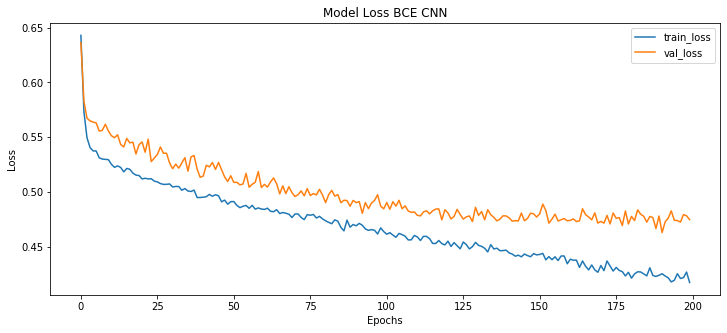

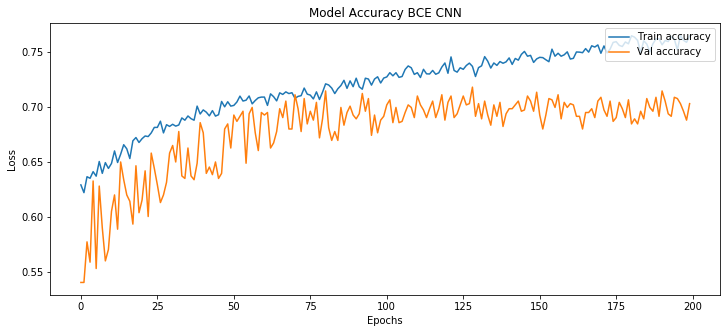

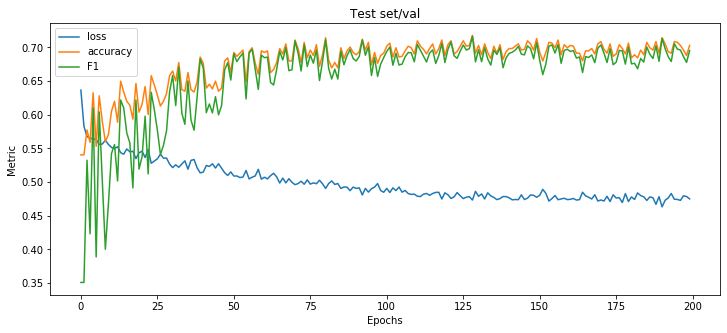

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.834367,0.755413,0.792929,0.747479,0.727971,0.743483
Confirmed,0.613435,0.721311,0.663014,0.747479,0.727971,0.743483


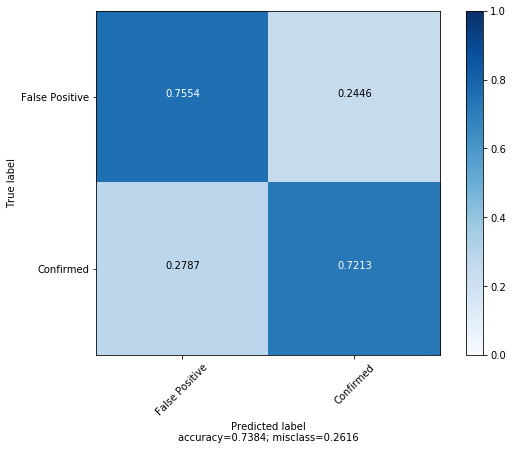

In [28]:
execute_main(n_up,n_down)

In [29]:
n_up = 10
n_down = 10

Objetos de entrenamiento: (8678, 20, 20, 2) (8678,)
Objetos de validación: (1918, 20, 20, 2) (1918,)
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 18, 18, 32)        608       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 9, 9, 32)          0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 9, 9, 32)          0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 7, 7, 32)          9248      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 3, 3, 32)          0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 3, 3, 32)          0         
___________________

7810/7810 [==============================] - 0s 28us/step - loss: 0.5083 - acc: 0.6860 - val_loss: 0.5401 - val_acc: 0.6475
 - val_f1: 0.597434 
Epoch 42/200
7810/7810 [==============================] - 0s 28us/step - loss: 0.5089 - acc: 0.6891 - val_loss: 0.5315 - val_acc: 0.6486
 - val_f1: 0.619267 
Epoch 43/200
7810/7810 [==============================] - 0s 28us/step - loss: 0.5076 - acc: 0.6869 - val_loss: 0.5313 - val_acc: 0.6406
 - val_f1: 0.614907 
Epoch 44/200
7810/7810 [==============================] - 0s 27us/step - loss: 0.5076 - acc: 0.6873 - val_loss: 0.5303 - val_acc: 0.6567
 - val_f1: 0.619905 
Epoch 45/200
7810/7810 [==============================] - 0s 28us/step - loss: 0.5047 - acc: 0.6941 - val_loss: 0.5322 - val_acc: 0.6567
 - val_f1: 0.616808 
Epoch 46/200
7810/7810 [==============================] - 0s 27us/step - loss: 0.5065 - acc: 0.6927 - val_loss: 0.5248 - val_acc: 0.6832
 - val_f1: 0.665974 
Epoch 47/200
7810/7810 [==============================] - 0s 28us

7810/7810 [==============================] - 0s 28us/step - loss: 0.4778 - acc: 0.7246 - val_loss: 0.4975 - val_acc: 0.6866
 - val_f1: 0.660225 
Epoch 94/200
7810/7810 [==============================] - 0s 29us/step - loss: 0.4777 - acc: 0.7218 - val_loss: 0.5034 - val_acc: 0.6832
 - val_f1: 0.651153 
Epoch 95/200
7810/7810 [==============================] - 0s 29us/step - loss: 0.4782 - acc: 0.7154 - val_loss: 0.4880 - val_acc: 0.6935
 - val_f1: 0.681023 
Epoch 96/200
7810/7810 [==============================] - 0s 29us/step - loss: 0.4752 - acc: 0.7222 - val_loss: 0.4921 - val_acc: 0.6924
 - val_f1: 0.672290 
Epoch 97/200
7810/7810 [==============================] - 0s 29us/step - loss: 0.4780 - acc: 0.7141 - val_loss: 0.4959 - val_acc: 0.6912
 - val_f1: 0.660811 
Epoch 98/200
7810/7810 [==============================] - 0s 28us/step - loss: 0.4751 - acc: 0.7198 - val_loss: 0.4908 - val_acc: 0.6993
 - val_f1: 0.678465 
Epoch 99/200
7810/7810 [==============================] - 0s 28us

 - val_f1: 0.676238 
Epoch 145/200
7810/7810 [==============================] - 0s 28us/step - loss: 0.4601 - acc: 0.7334 - val_loss: 0.4849 - val_acc: 0.6889
 - val_f1: 0.663191 
Epoch 146/200
7810/7810 [==============================] - 0s 27us/step - loss: 0.4555 - acc: 0.7367 - val_loss: 0.4809 - val_acc: 0.6959
 - val_f1: 0.673312 
Epoch 147/200
7810/7810 [==============================] - 0s 28us/step - loss: 0.4538 - acc: 0.7370 - val_loss: 0.4770 - val_acc: 0.7051
 - val_f1: 0.694151 
Epoch 148/200
7810/7810 [==============================] - 0s 27us/step - loss: 0.4555 - acc: 0.7346 - val_loss: 0.4796 - val_acc: 0.6947
 - val_f1: 0.673125 
Epoch 149/200
7810/7810 [==============================] - 0s 27us/step - loss: 0.4540 - acc: 0.7382 - val_loss: 0.4806 - val_acc: 0.6912
 - val_f1: 0.667046 
Epoch 150/200
7810/7810 [==============================] - 0s 27us/step - loss: 0.4570 - acc: 0.7342 - val_loss: 0.4709 - val_acc: 0.7120
 - val_f1: 0.698737 
Epoch 151/200
7810/7810 [

7810/7810 [==============================] - 0s 28us/step - loss: 0.4408 - acc: 0.7446 - val_loss: 0.4723 - val_acc: 0.6947
 - val_f1: 0.675911 
Epoch 197/200
7810/7810 [==============================] - 0s 28us/step - loss: 0.4460 - acc: 0.7425 - val_loss: 0.4710 - val_acc: 0.7085
 - val_f1: 0.694339 
Epoch 198/200
7810/7810 [==============================] - 0s 28us/step - loss: 0.4418 - acc: 0.7426 - val_loss: 0.4680 - val_acc: 0.7258
 - val_f1: 0.717132 
Epoch 199/200
7810/7810 [==============================] - 0s 28us/step - loss: 0.4465 - acc: 0.7437 - val_loss: 0.4709 - val_acc: 0.6993
 - val_f1: 0.681177 
Epoch 200/200
7810/7810 [==============================] - 0s 29us/step - loss: 0.4442 - acc: 0.7399 - val_loss: 0.4697 - val_acc: 0.6970
 - val_f1: 0.677200 


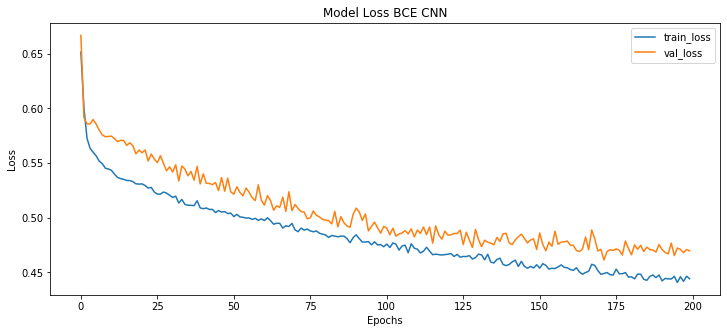

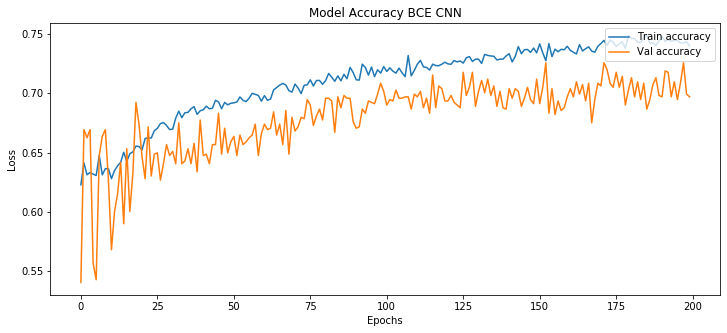

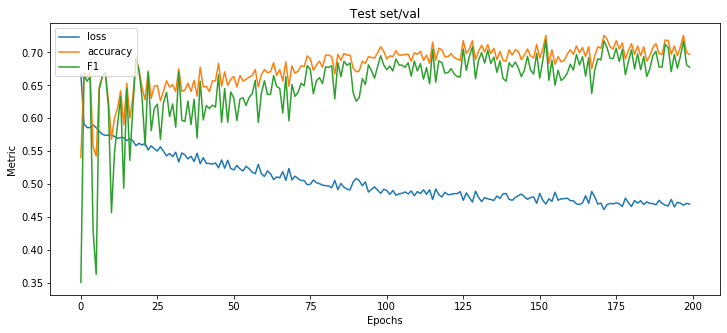

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.792366,0.832398,0.811889,0.746131,0.717907,0.749218
Confirmed,0.656250,0.594635,0.623925,0.746131,0.717907,0.749218


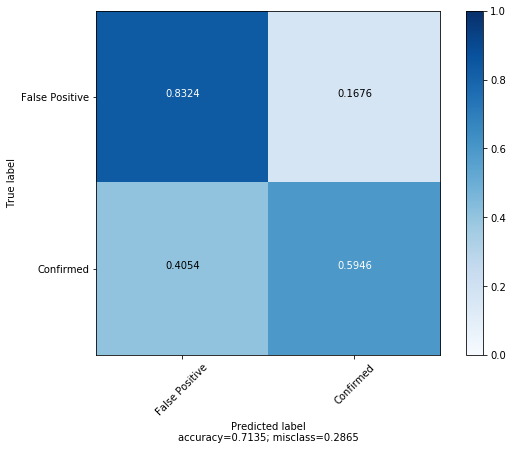

In [30]:
execute_main(n_up,n_down)

In [51]:
n_up = 10
n_down = 15

Objetos de entrenamiento: (8678, 25, 25, 2) (8678,)
Objetos de validación: (1918, 25, 25, 2) (1918,)
Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_35 (Conv2D)           (None, 23, 23, 32)        608       
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 11, 11, 32)        0         
_________________________________________________________________
dropout_52 (Dropout)         (None, 11, 11, 32)        0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 9, 9, 32)          9248      
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 4, 4, 32)          0         
_________________________________________________________________
dropout_53 (Dropout)         (None, 4, 4, 32)          0         
__________________

7810/7810 [==============================] - 0s 37us/step - loss: 0.5037 - acc: 0.6951 - val_loss: 0.5273 - val_acc: 0.6774
 - val_f1: 0.660458 
Epoch 42/200
7810/7810 [==============================] - 0s 37us/step - loss: 0.5041 - acc: 0.6898 - val_loss: 0.5294 - val_acc: 0.6636
 - val_f1: 0.645129 
Epoch 43/200
7810/7810 [==============================] - 0s 37us/step - loss: 0.5034 - acc: 0.6977 - val_loss: 0.5319 - val_acc: 0.6624
 - val_f1: 0.625385 
Epoch 44/200
7810/7810 [==============================] - 0s 38us/step - loss: 0.5025 - acc: 0.6886 - val_loss: 0.5267 - val_acc: 0.6659
 - val_f1: 0.635676 
Epoch 45/200
7810/7810 [==============================] - 0s 37us/step - loss: 0.5056 - acc: 0.6869 - val_loss: 0.5292 - val_acc: 0.6705
 - val_f1: 0.631625 
Epoch 46/200
7810/7810 [==============================] - 0s 39us/step - loss: 0.5040 - acc: 0.6948 - val_loss: 0.5394 - val_acc: 0.6406
 - val_f1: 0.575406 
Epoch 47/200
7810/7810 [==============================] - 0s 38us

7810/7810 [==============================] - 0s 37us/step - loss: 0.4752 - acc: 0.7168 - val_loss: 0.4909 - val_acc: 0.6993
 - val_f1: 0.678866 
Epoch 94/200
7810/7810 [==============================] - 0s 36us/step - loss: 0.4691 - acc: 0.7271 - val_loss: 0.4933 - val_acc: 0.6843
 - val_f1: 0.659134 
Epoch 95/200
7810/7810 [==============================] - 0s 38us/step - loss: 0.4771 - acc: 0.7140 - val_loss: 0.4935 - val_acc: 0.6889
 - val_f1: 0.666319 
Epoch 96/200
7810/7810 [==============================] - 0s 38us/step - loss: 0.4719 - acc: 0.7243 - val_loss: 0.4825 - val_acc: 0.7051
 - val_f1: 0.695739 
Epoch 97/200
7810/7810 [==============================] - 0s 37us/step - loss: 0.4691 - acc: 0.7233 - val_loss: 0.4914 - val_acc: 0.6935
 - val_f1: 0.669971 
Epoch 98/200
7810/7810 [==============================] - 0s 38us/step - loss: 0.4712 - acc: 0.7204 - val_loss: 0.4915 - val_acc: 0.6947
 - val_f1: 0.668272 
Epoch 99/200
7810/7810 [==============================] - 0s 39us

 - val_f1: 0.696522 
Epoch 145/200
7810/7810 [==============================] - 0s 37us/step - loss: 0.4542 - acc: 0.7344 - val_loss: 0.4782 - val_acc: 0.7120
 - val_f1: 0.689823 
Epoch 146/200
7810/7810 [==============================] - 0s 37us/step - loss: 0.4535 - acc: 0.7362 - val_loss: 0.4708 - val_acc: 0.7120
 - val_f1: 0.698120 
Epoch 147/200
7810/7810 [==============================] - 0s 37us/step - loss: 0.4522 - acc: 0.7341 - val_loss: 0.4684 - val_acc: 0.7143
 - val_f1: 0.708136 
Epoch 148/200
7810/7810 [==============================] - 0s 37us/step - loss: 0.4543 - acc: 0.7364 - val_loss: 0.4748 - val_acc: 0.7005
 - val_f1: 0.681459 
Epoch 149/200
7810/7810 [==============================] - 0s 37us/step - loss: 0.4550 - acc: 0.7346 - val_loss: 0.4739 - val_acc: 0.7051
 - val_f1: 0.685213 
Epoch 150/200
7810/7810 [==============================] - 0s 37us/step - loss: 0.4516 - acc: 0.7350 - val_loss: 0.4763 - val_acc: 0.7062
 - val_f1: 0.685857 
Epoch 151/200
7810/7810 [

7810/7810 [==============================] - 0s 37us/step - loss: 0.4409 - acc: 0.7533 - val_loss: 0.4642 - val_acc: 0.7028
 - val_f1: 0.685024 
Epoch 197/200
7810/7810 [==============================] - 0s 36us/step - loss: 0.4374 - acc: 0.7510 - val_loss: 0.4608 - val_acc: 0.7200
 - val_f1: 0.709015 
Epoch 198/200
7810/7810 [==============================] - 0s 37us/step - loss: 0.4370 - acc: 0.7494 - val_loss: 0.4608 - val_acc: 0.7085
 - val_f1: 0.694655 
Epoch 199/200
7810/7810 [==============================] - 0s 37us/step - loss: 0.4383 - acc: 0.7499 - val_loss: 0.4608 - val_acc: 0.7131
 - val_f1: 0.695835 
Epoch 200/200
7810/7810 [==============================] - 0s 38us/step - loss: 0.4327 - acc: 0.7548 - val_loss: 0.4625 - val_acc: 0.7131
 - val_f1: 0.698856 


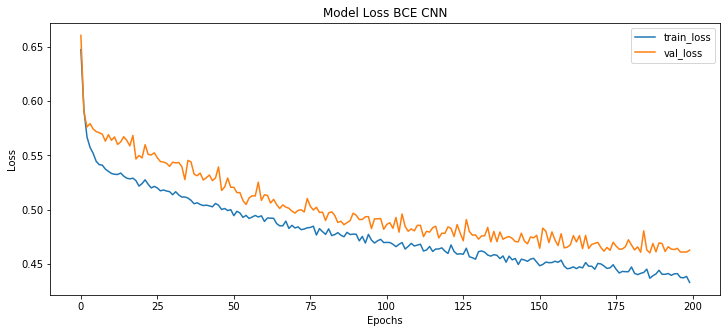

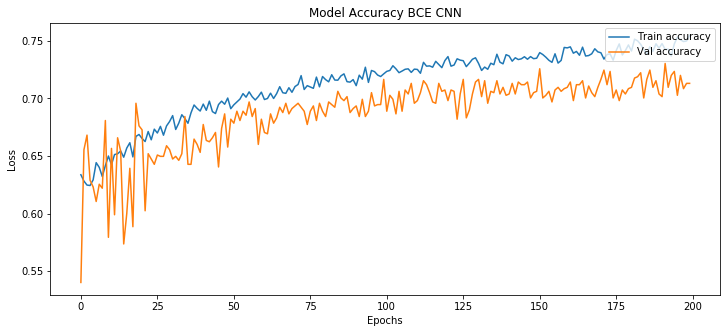

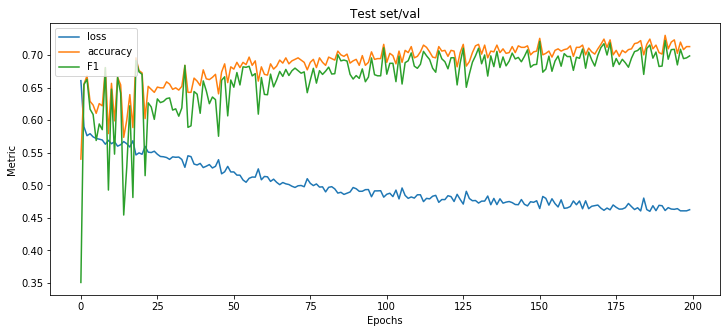

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.799546,0.847634,0.822888,0.759215,0.731886,0.762774
Confirmed,0.681208,0.605067,0.640884,0.759215,0.731886,0.762774


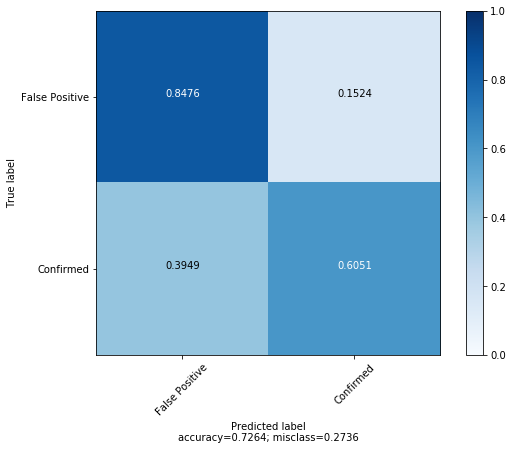

In [52]:
execute_main(n_up,n_down)

In [49]:
n_up = 10
n_down = 30

Objetos de entrenamiento: (8678, 40, 40, 2) (8678,)
Objetos de validación: (1918, 40, 40, 2) (1918,)
Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_33 (Conv2D)           (None, 38, 38, 32)        608       
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 19, 19, 32)        0         
_________________________________________________________________
dropout_49 (Dropout)         (None, 19, 19, 32)        0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 17, 17, 32)        9248      
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 8, 8, 32)          0         
_________________________________________________________________
dropout_50 (Dropout)         (None, 8, 8, 32)          0         
__________________

7810/7810 [==============================] - 1s 70us/step - loss: 0.4908 - acc: 0.7022 - val_loss: 0.5075 - val_acc: 0.6866
 - val_f1: 0.683814 
Epoch 42/200
7810/7810 [==============================] - 1s 71us/step - loss: 0.4922 - acc: 0.7038 - val_loss: 0.5203 - val_acc: 0.6371
 - val_f1: 0.600412 
Epoch 43/200
7810/7810 [==============================] - 1s 72us/step - loss: 0.4913 - acc: 0.7022 - val_loss: 0.5237 - val_acc: 0.6406
 - val_f1: 0.597460 
Epoch 44/200
7810/7810 [==============================] - 1s 72us/step - loss: 0.4876 - acc: 0.7078 - val_loss: 0.5189 - val_acc: 0.6417
 - val_f1: 0.610136 
Epoch 45/200
7810/7810 [==============================] - 1s 72us/step - loss: 0.4906 - acc: 0.7055 - val_loss: 0.5186 - val_acc: 0.6417
 - val_f1: 0.610136 
Epoch 46/200
7810/7810 [==============================] - 1s 72us/step - loss: 0.4877 - acc: 0.7079 - val_loss: 0.5127 - val_acc: 0.6555
 - val_f1: 0.641957 
Epoch 47/200
7810/7810 [==============================] - 1s 72us

7810/7810 [==============================] - 1s 71us/step - loss: 0.4625 - acc: 0.7298 - val_loss: 0.4879 - val_acc: 0.6924
 - val_f1: 0.681436 
Epoch 94/200
7810/7810 [==============================] - 1s 71us/step - loss: 0.4588 - acc: 0.7321 - val_loss: 0.4861 - val_acc: 0.6947
 - val_f1: 0.682373 
Epoch 95/200
7810/7810 [==============================] - 1s 71us/step - loss: 0.4640 - acc: 0.7298 - val_loss: 0.4860 - val_acc: 0.7131
 - val_f1: 0.711414 
Epoch 96/200
7810/7810 [==============================] - 1s 70us/step - loss: 0.4631 - acc: 0.7279 - val_loss: 0.4848 - val_acc: 0.7131
 - val_f1: 0.709506 
Epoch 97/200
7810/7810 [==============================] - 1s 70us/step - loss: 0.4630 - acc: 0.7348 - val_loss: 0.4936 - val_acc: 0.6797
 - val_f1: 0.665664 
Epoch 98/200
7810/7810 [==============================] - 1s 71us/step - loss: 0.4565 - acc: 0.7329 - val_loss: 0.4845 - val_acc: 0.7016
 - val_f1: 0.694439 
Epoch 99/200
7810/7810 [==============================] - 1s 70us

 - val_f1: 0.701923 
Epoch 145/200
7810/7810 [==============================] - 1s 71us/step - loss: 0.4354 - acc: 0.7494 - val_loss: 0.4783 - val_acc: 0.6924
 - val_f1: 0.680864 
Epoch 146/200
7810/7810 [==============================] - 1s 70us/step - loss: 0.4418 - acc: 0.7502 - val_loss: 0.4808 - val_acc: 0.6901
 - val_f1: 0.664206 
Epoch 147/200
7810/7810 [==============================] - 1s 69us/step - loss: 0.4380 - acc: 0.7476 - val_loss: 0.4772 - val_acc: 0.7016
 - val_f1: 0.684706 
Epoch 148/200
7810/7810 [==============================] - 1s 70us/step - loss: 0.4409 - acc: 0.7396 - val_loss: 0.4671 - val_acc: 0.7085
 - val_f1: 0.705836 
Epoch 149/200
7810/7810 [==============================] - 1s 70us/step - loss: 0.4358 - acc: 0.7465 - val_loss: 0.4699 - val_acc: 0.6993
 - val_f1: 0.688869 
Epoch 150/200
7810/7810 [==============================] - 1s 71us/step - loss: 0.4418 - acc: 0.7456 - val_loss: 0.4717 - val_acc: 0.7062
 - val_f1: 0.700399 
Epoch 151/200
7810/7810 [

7810/7810 [==============================] - 1s 72us/step - loss: 0.4187 - acc: 0.7636 - val_loss: 0.4569 - val_acc: 0.7120
 - val_f1: 0.709388 
Epoch 197/200
7810/7810 [==============================] - 1s 71us/step - loss: 0.4184 - acc: 0.7599 - val_loss: 0.4618 - val_acc: 0.7131
 - val_f1: 0.708537 
Epoch 198/200
7810/7810 [==============================] - 1s 70us/step - loss: 0.4171 - acc: 0.7617 - val_loss: 0.4642 - val_acc: 0.7085
 - val_f1: 0.701942 
Epoch 199/200
7810/7810 [==============================] - 1s 74us/step - loss: 0.4223 - acc: 0.7617 - val_loss: 0.4627 - val_acc: 0.7051
 - val_f1: 0.700076 
Epoch 200/200
7810/7810 [==============================] - 1s 70us/step - loss: 0.4165 - acc: 0.7659 - val_loss: 0.4673 - val_acc: 0.7028
 - val_f1: 0.695284 


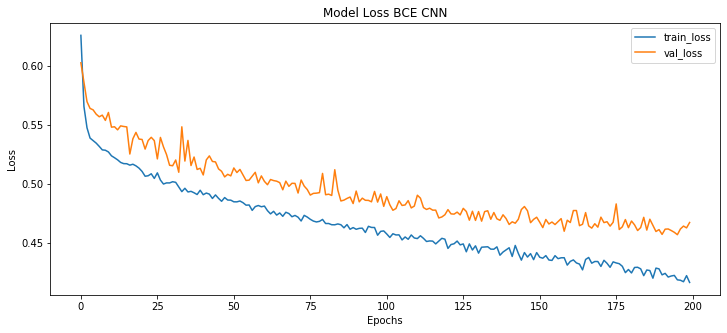

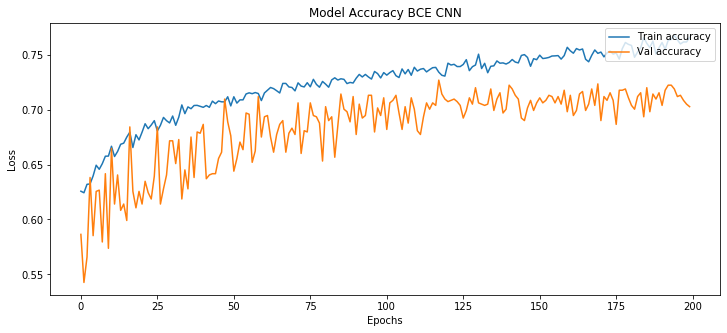

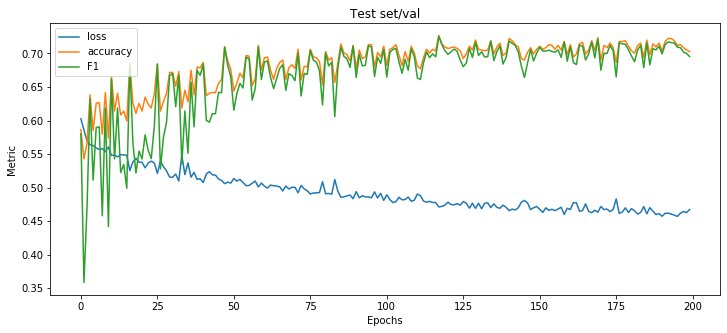

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.815961,0.803528,0.809697,0.755203,0.731814,0.754432
Confirmed,0.644928,0.663189,0.653931,0.755203,0.731814,0.754432


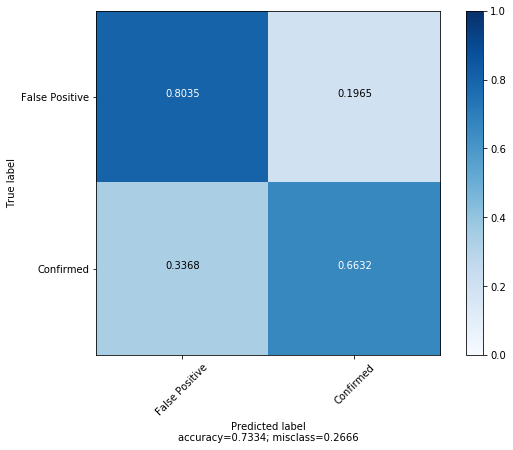

In [50]:
execute_main(n_up,n_down)

In [35]:
n_up = 15
n_down = 10

Objetos de entrenamiento: (8678, 25, 25, 2) (8678,)
Objetos de validación: (1918, 25, 25, 2) (1918,)
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 23, 23, 32)        608       
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 11, 11, 32)        0         
_________________________________________________________________
dropout_28 (Dropout)         (None, 11, 11, 32)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 9, 9, 32)          9248      
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 4, 4, 32)          0         
_________________________________________________________________
dropout_29 (Dropout)         (None, 4, 4, 32)          0         
__________________

7810/7810 [==============================] - 0s 36us/step - loss: 0.5091 - acc: 0.6877 - val_loss: 0.5403 - val_acc: 0.6578
 - val_f1: 0.624956 
Epoch 42/200
7810/7810 [==============================] - 0s 36us/step - loss: 0.5094 - acc: 0.6816 - val_loss: 0.5399 - val_acc: 0.6521
 - val_f1: 0.617197 
Epoch 43/200
7810/7810 [==============================] - 0s 36us/step - loss: 0.5091 - acc: 0.6898 - val_loss: 0.5454 - val_acc: 0.6406
 - val_f1: 0.588002 
Epoch 44/200
7810/7810 [==============================] - 0s 36us/step - loss: 0.5071 - acc: 0.6887 - val_loss: 0.5424 - val_acc: 0.6475
 - val_f1: 0.598177 
Epoch 45/200
7810/7810 [==============================] - 0s 36us/step - loss: 0.5052 - acc: 0.6915 - val_loss: 0.5330 - val_acc: 0.6682
 - val_f1: 0.647574 
Epoch 46/200
7810/7810 [==============================] - 0s 35us/step - loss: 0.5027 - acc: 0.6941 - val_loss: 0.5280 - val_acc: 0.6717
 - val_f1: 0.657747 
Epoch 47/200
7810/7810 [==============================] - 0s 35us

7810/7810 [==============================] - 0s 35us/step - loss: 0.4761 - acc: 0.7198 - val_loss: 0.5126 - val_acc: 0.6843
 - val_f1: 0.656763 
Epoch 94/200
7810/7810 [==============================] - 0s 35us/step - loss: 0.4760 - acc: 0.7283 - val_loss: 0.4981 - val_acc: 0.6959
 - val_f1: 0.690322 
Epoch 95/200
7810/7810 [==============================] - 0s 35us/step - loss: 0.4755 - acc: 0.7225 - val_loss: 0.4994 - val_acc: 0.6866
 - val_f1: 0.674740 
Epoch 96/200
7810/7810 [==============================] - 0s 36us/step - loss: 0.4707 - acc: 0.7286 - val_loss: 0.5063 - val_acc: 0.6751
 - val_f1: 0.649181 
Epoch 97/200
7810/7810 [==============================] - 0s 36us/step - loss: 0.4755 - acc: 0.7230 - val_loss: 0.5038 - val_acc: 0.6889
 - val_f1: 0.675603 
Epoch 98/200
7810/7810 [==============================] - 0s 35us/step - loss: 0.4734 - acc: 0.7245 - val_loss: 0.4984 - val_acc: 0.7016
 - val_f1: 0.695085 
Epoch 99/200
7810/7810 [==============================] - 0s 35us

 - val_f1: 0.669215 
Epoch 145/200
7810/7810 [==============================] - 0s 35us/step - loss: 0.4512 - acc: 0.7434 - val_loss: 0.4971 - val_acc: 0.6924
 - val_f1: 0.670658 
Epoch 146/200
7810/7810 [==============================] - 0s 35us/step - loss: 0.4464 - acc: 0.7513 - val_loss: 0.5230 - val_acc: 0.6717
 - val_f1: 0.623300 
Epoch 147/200
7810/7810 [==============================] - 0s 35us/step - loss: 0.4539 - acc: 0.7461 - val_loss: 0.4971 - val_acc: 0.6901
 - val_f1: 0.666470 
Epoch 148/200
7810/7810 [==============================] - 0s 35us/step - loss: 0.4448 - acc: 0.7528 - val_loss: 0.4842 - val_acc: 0.7005
 - val_f1: 0.690196 
Epoch 149/200
7810/7810 [==============================] - 0s 35us/step - loss: 0.4462 - acc: 0.7517 - val_loss: 0.4966 - val_acc: 0.7016
 - val_f1: 0.680119 
Epoch 150/200
7810/7810 [==============================] - 0s 35us/step - loss: 0.4482 - acc: 0.7469 - val_loss: 0.5086 - val_acc: 0.6786
 - val_f1: 0.643856 
Epoch 151/200
7810/7810 [

7810/7810 [==============================] - 0s 36us/step - loss: 0.4283 - acc: 0.7603 - val_loss: 0.4895 - val_acc: 0.7051
 - val_f1: 0.680655 
Epoch 197/200
7810/7810 [==============================] - 0s 35us/step - loss: 0.4316 - acc: 0.7640 - val_loss: 0.5042 - val_acc: 0.6866
 - val_f1: 0.654157 
Epoch 198/200
7810/7810 [==============================] - 0s 36us/step - loss: 0.4279 - acc: 0.7609 - val_loss: 0.4777 - val_acc: 0.7120
 - val_f1: 0.697805 
Epoch 199/200
7810/7810 [==============================] - 0s 35us/step - loss: 0.4312 - acc: 0.7682 - val_loss: 0.4926 - val_acc: 0.6947
 - val_f1: 0.672287 
Epoch 200/200
7810/7810 [==============================] - 0s 35us/step - loss: 0.4292 - acc: 0.7689 - val_loss: 0.4870 - val_acc: 0.7028
 - val_f1: 0.684657 


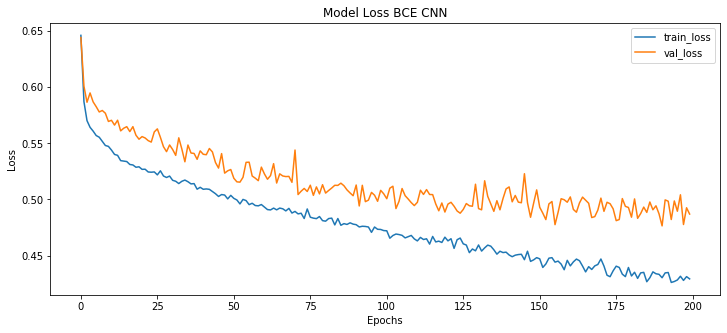

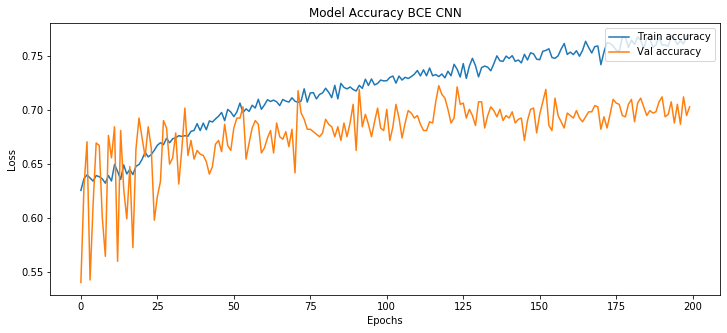

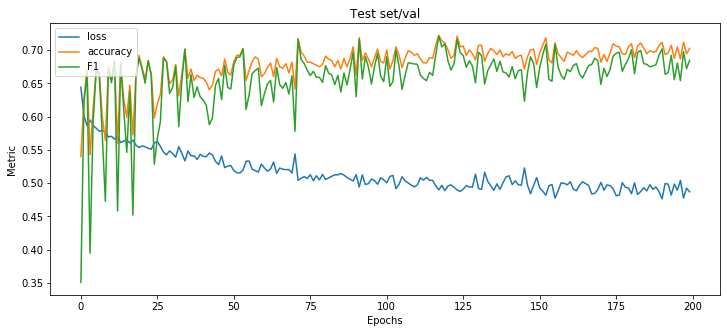

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.798589,0.817161,0.807769,0.745793,0.719193,0.747132
Confirmed,0.644860,0.616990,0.630617,0.745793,0.719193,0.747132


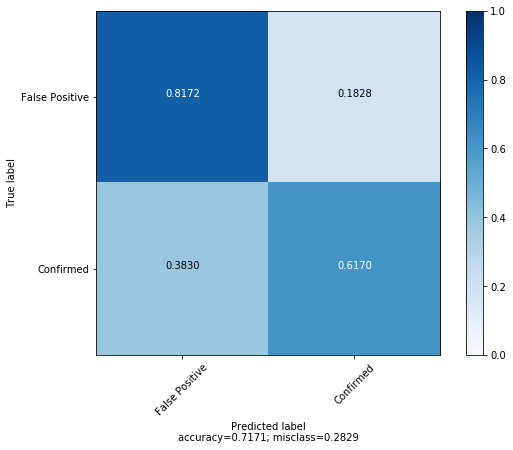

In [36]:
execute_main(n_up,n_down)

In [47]:
n_up = 16
n_down = 16

Objetos de entrenamiento: (8678, 32, 32, 2) (8678,)
Objetos de validación: (1918, 32, 32, 2) (1918,)
Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_31 (Conv2D)           (None, 30, 30, 32)        608       
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_46 (Dropout)         (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 13, 13, 32)        9248      
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 6, 6, 32)          0         
_________________________________________________________________
dropout_47 (Dropout)         (None, 6, 6, 32)          0         
__________________

7810/7810 [==============================] - 0s 50us/step - loss: 0.4969 - acc: 0.6991 - val_loss: 0.5165 - val_acc: 0.6797
 - val_f1: 0.657736 
Epoch 42/200
7810/7810 [==============================] - 0s 50us/step - loss: 0.4928 - acc: 0.7051 - val_loss: 0.5148 - val_acc: 0.6694
 - val_f1: 0.642230 
Epoch 43/200
7810/7810 [==============================] - 0s 51us/step - loss: 0.4936 - acc: 0.7014 - val_loss: 0.5111 - val_acc: 0.6855
 - val_f1: 0.667663 
Epoch 44/200
7810/7810 [==============================] - 0s 50us/step - loss: 0.4928 - acc: 0.7038 - val_loss: 0.5076 - val_acc: 0.6889
 - val_f1: 0.682879 
Epoch 45/200
7810/7810 [==============================] - 0s 53us/step - loss: 0.4963 - acc: 0.7070 - val_loss: 0.5203 - val_acc: 0.6509
 - val_f1: 0.606031 
Epoch 46/200
7810/7810 [==============================] - 0s 54us/step - loss: 0.4944 - acc: 0.7000 - val_loss: 0.5068 - val_acc: 0.6912
 - val_f1: 0.681209 
Epoch 47/200
7810/7810 [==============================] - 0s 52us

7810/7810 [==============================] - 0s 50us/step - loss: 0.4606 - acc: 0.7379 - val_loss: 0.4785 - val_acc: 0.7293
 - val_f1: 0.725839 
Epoch 94/200
7810/7810 [==============================] - 0s 50us/step - loss: 0.4539 - acc: 0.7392 - val_loss: 0.4772 - val_acc: 0.7270
 - val_f1: 0.723648 
Epoch 95/200
7810/7810 [==============================] - 0s 50us/step - loss: 0.4531 - acc: 0.7408 - val_loss: 0.4820 - val_acc: 0.7108
 - val_f1: 0.693747 
Epoch 96/200
7810/7810 [==============================] - 0s 50us/step - loss: 0.4530 - acc: 0.7425 - val_loss: 0.4752 - val_acc: 0.7085
 - val_f1: 0.697871 
Epoch 97/200
7810/7810 [==============================] - 0s 50us/step - loss: 0.4522 - acc: 0.7438 - val_loss: 0.4810 - val_acc: 0.7097
 - val_f1: 0.694742 
Epoch 98/200
7810/7810 [==============================] - 0s 51us/step - loss: 0.4532 - acc: 0.7417 - val_loss: 0.4784 - val_acc: 0.7120
 - val_f1: 0.695833 
Epoch 99/200
7810/7810 [==============================] - 0s 50us

 - val_f1: 0.714367 
Epoch 145/200
7810/7810 [==============================] - 0s 49us/step - loss: 0.4278 - acc: 0.7658 - val_loss: 0.4443 - val_acc: 0.7523
 - val_f1: 0.747559 
Epoch 146/200
7810/7810 [==============================] - 0s 50us/step - loss: 0.4311 - acc: 0.7648 - val_loss: 0.4501 - val_acc: 0.7512
 - val_f1: 0.745442 
Epoch 147/200
7810/7810 [==============================] - 0s 50us/step - loss: 0.4252 - acc: 0.7677 - val_loss: 0.4509 - val_acc: 0.7477
 - val_f1: 0.740657 
Epoch 148/200
7810/7810 [==============================] - 0s 50us/step - loss: 0.4310 - acc: 0.7625 - val_loss: 0.4542 - val_acc: 0.7385
 - val_f1: 0.730093 
Epoch 149/200
7810/7810 [==============================] - 0s 50us/step - loss: 0.4294 - acc: 0.7633 - val_loss: 0.4580 - val_acc: 0.7362
 - val_f1: 0.719938 
Epoch 150/200
7810/7810 [==============================] - 0s 50us/step - loss: 0.4279 - acc: 0.7634 - val_loss: 0.4562 - val_acc: 0.7247
 - val_f1: 0.712708 
Epoch 151/200
7810/7810 [

7810/7810 [==============================] - 0s 50us/step - loss: 0.4039 - acc: 0.7784 - val_loss: 0.4329 - val_acc: 0.7604
 - val_f1: 0.753779 
Epoch 197/200
7810/7810 [==============================] - 0s 50us/step - loss: 0.4065 - acc: 0.7773 - val_loss: 0.4337 - val_acc: 0.7615
 - val_f1: 0.755428 
Epoch 198/200
7810/7810 [==============================] - 0s 50us/step - loss: 0.4118 - acc: 0.7713 - val_loss: 0.4403 - val_acc: 0.7477
 - val_f1: 0.736749 
Epoch 199/200
7810/7810 [==============================] - 0s 51us/step - loss: 0.4051 - acc: 0.7754 - val_loss: 0.4389 - val_acc: 0.7581
 - val_f1: 0.748649 
Epoch 200/200
7810/7810 [==============================] - 0s 50us/step - loss: 0.4072 - acc: 0.7793 - val_loss: 0.4331 - val_acc: 0.7558
 - val_f1: 0.748649 


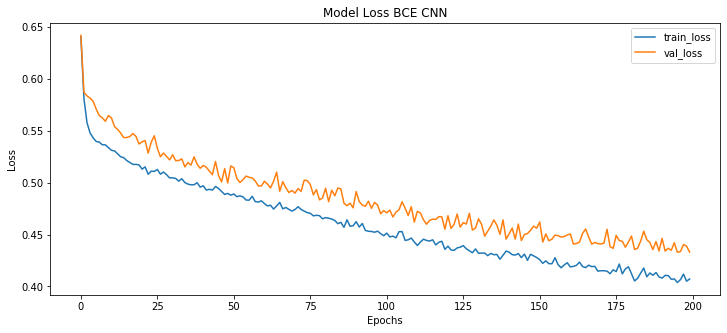

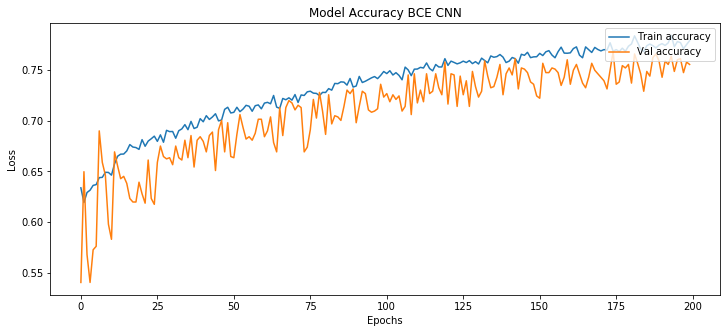

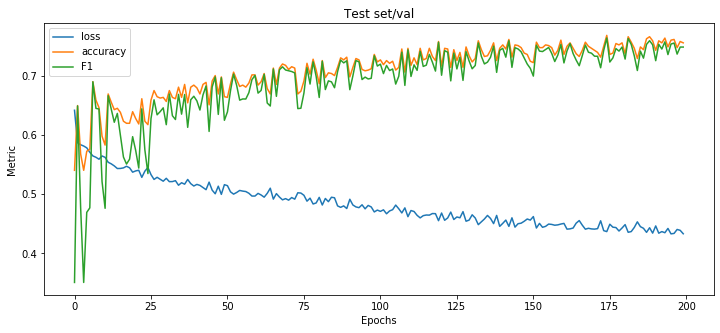

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.817424,0.865277,0.840670,0.783656,0.759185,0.786757
Confirmed,0.719064,0.640835,0.677699,0.783656,0.759185,0.786757


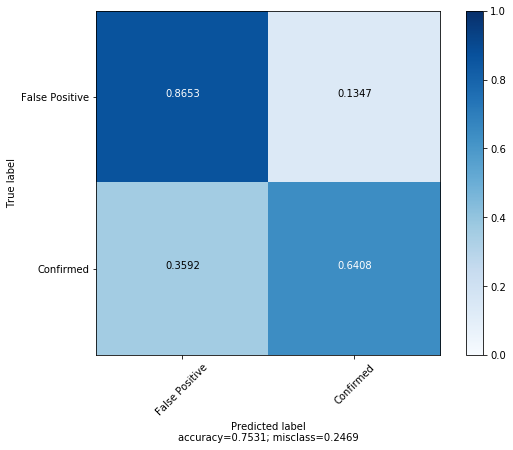

In [48]:
execute_main(n_up,n_down)

In [39]:
n_up = 15
n_down = 30

Objetos de entrenamiento: (8678, 45, 45, 2) (8678,)
Objetos de validación: (1918, 45, 45, 2) (1918,)
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_23 (Conv2D)           (None, 43, 43, 32)        608       
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 21, 21, 32)        0         
_________________________________________________________________
dropout_34 (Dropout)         (None, 21, 21, 32)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 19, 19, 32)        9248      
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 9, 9, 32)          0         
_________________________________________________________________
dropout_35 (Dropout)         (None, 9, 9, 32)          0         
__________________

7810/7810 [==============================] - 1s 83us/step - loss: 0.4930 - acc: 0.7070 - val_loss: 0.5153 - val_acc: 0.6866
 - val_f1: 0.680530 
Epoch 42/200
7810/7810 [==============================] - 1s 84us/step - loss: 0.4933 - acc: 0.7072 - val_loss: 0.5221 - val_acc: 0.6659
 - val_f1: 0.650179 
Epoch 43/200
7810/7810 [==============================] - 1s 84us/step - loss: 0.4945 - acc: 0.6985 - val_loss: 0.5127 - val_acc: 0.6740
 - val_f1: 0.669840 
Epoch 44/200
7810/7810 [==============================] - 1s 84us/step - loss: 0.4915 - acc: 0.7076 - val_loss: 0.5172 - val_acc: 0.6740
 - val_f1: 0.664604 
Epoch 45/200
7810/7810 [==============================] - 1s 84us/step - loss: 0.4915 - acc: 0.7049 - val_loss: 0.5160 - val_acc: 0.6763
 - val_f1: 0.666164 
Epoch 46/200
7810/7810 [==============================] - 1s 84us/step - loss: 0.4901 - acc: 0.7052 - val_loss: 0.5186 - val_acc: 0.6671
 - val_f1: 0.647382 
Epoch 47/200
7810/7810 [==============================] - 1s 84us

7810/7810 [==============================] - 1s 84us/step - loss: 0.4622 - acc: 0.7250 - val_loss: 0.4855 - val_acc: 0.7120
 - val_f1: 0.708564 
Epoch 94/200
7810/7810 [==============================] - 1s 85us/step - loss: 0.4632 - acc: 0.7283 - val_loss: 0.4834 - val_acc: 0.7131
 - val_f1: 0.710356 
Epoch 95/200
7810/7810 [==============================] - 1s 84us/step - loss: 0.4678 - acc: 0.7282 - val_loss: 0.4838 - val_acc: 0.7143
 - val_f1: 0.710597 
Epoch 96/200
7810/7810 [==============================] - 1s 84us/step - loss: 0.4656 - acc: 0.7234 - val_loss: 0.4896 - val_acc: 0.7074
 - val_f1: 0.699557 
Epoch 97/200
7810/7810 [==============================] - 1s 84us/step - loss: 0.4587 - acc: 0.7294 - val_loss: 0.4812 - val_acc: 0.7212
 - val_f1: 0.717746 
Epoch 98/200
7810/7810 [==============================] - 1s 83us/step - loss: 0.4627 - acc: 0.7309 - val_loss: 0.4852 - val_acc: 0.7189
 - val_f1: 0.714638 
Epoch 99/200
7810/7810 [==============================] - 1s 84us

 - val_f1: 0.714474 
Epoch 145/200
7810/7810 [==============================] - 1s 83us/step - loss: 0.4419 - acc: 0.7469 - val_loss: 0.4672 - val_acc: 0.7258
 - val_f1: 0.724400 
Epoch 146/200
7810/7810 [==============================] - 1s 84us/step - loss: 0.4364 - acc: 0.7502 - val_loss: 0.4854 - val_acc: 0.7005
 - val_f1: 0.682212 
Epoch 147/200
7810/7810 [==============================] - 1s 84us/step - loss: 0.4442 - acc: 0.7411 - val_loss: 0.4640 - val_acc: 0.7247
 - val_f1: 0.723462 
Epoch 148/200
7810/7810 [==============================] - 1s 83us/step - loss: 0.4396 - acc: 0.7503 - val_loss: 0.4646 - val_acc: 0.7362
 - val_f1: 0.734296 
Epoch 149/200
7810/7810 [==============================] - 1s 84us/step - loss: 0.4416 - acc: 0.7415 - val_loss: 0.4827 - val_acc: 0.7005
 - val_f1: 0.682212 
Epoch 150/200
7810/7810 [==============================] - 1s 84us/step - loss: 0.4377 - acc: 0.7492 - val_loss: 0.4702 - val_acc: 0.7200
 - val_f1: 0.713521 
Epoch 151/200
7810/7810 [

7810/7810 [==============================] - 1s 84us/step - loss: 0.4162 - acc: 0.7633 - val_loss: 0.4641 - val_acc: 0.7293
 - val_f1: 0.725547 
Epoch 197/200
7810/7810 [==============================] - 1s 84us/step - loss: 0.4192 - acc: 0.7594 - val_loss: 0.4703 - val_acc: 0.7270
 - val_f1: 0.721547 
Epoch 198/200
7810/7810 [==============================] - 1s 84us/step - loss: 0.4198 - acc: 0.7620 - val_loss: 0.4617 - val_acc: 0.7327
 - val_f1: 0.732258 
Epoch 199/200
7810/7810 [==============================] - 1s 84us/step - loss: 0.4186 - acc: 0.7627 - val_loss: 0.4700 - val_acc: 0.7293
 - val_f1: 0.725085 
Epoch 200/200
7810/7810 [==============================] - 1s 84us/step - loss: 0.4173 - acc: 0.7662 - val_loss: 0.4602 - val_acc: 0.7327
 - val_f1: 0.730192 


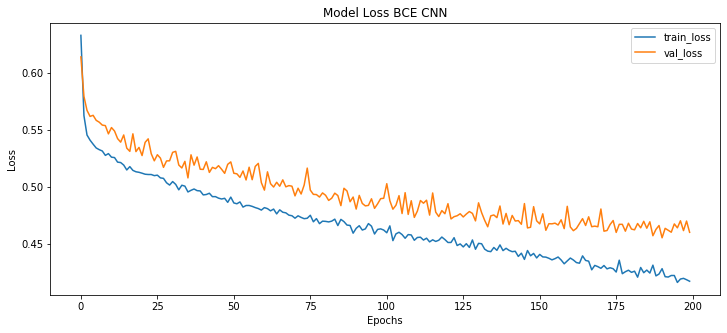

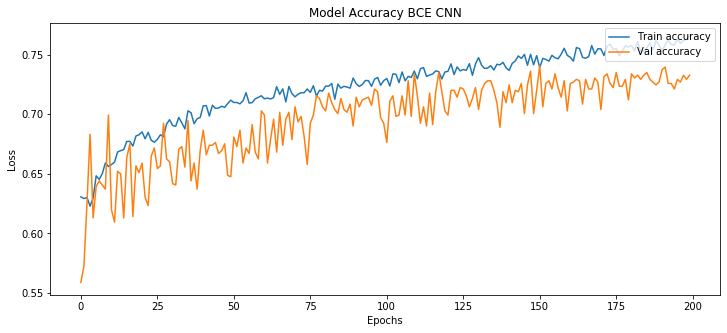

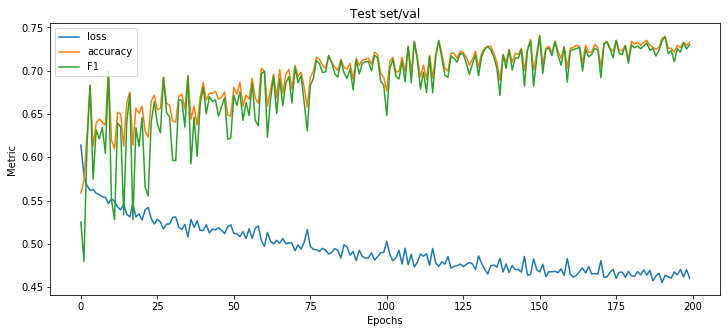

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.832916,0.799519,0.815876,0.767194,0.7463,0.765381
Confirmed,0.653259,0.701937,0.676724,0.767194,0.7463,0.765381


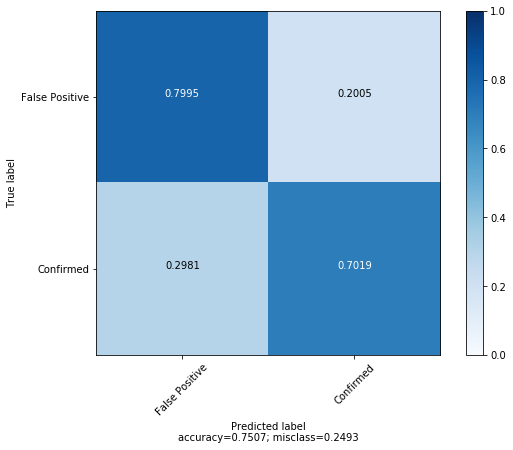

In [40]:
execute_main(n_up,n_down)

In [41]:
n_up = 32
n_down = 32

Objetos de entrenamiento: (8678, 64, 64, 2) (8678,)
Objetos de validación: (1918, 64, 64, 2) (1918,)
Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 62, 62, 32)        608       
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
dropout_37 (Dropout)         (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 29, 29, 32)        9248      
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_38 (Dropout)         (None, 14, 14, 32)        0         
__________________

7810/7810 [==============================] - 1s 160us/step - loss: 0.5001 - acc: 0.6969 - val_loss: 0.5185 - val_acc: 0.7005
 - val_f1: 0.697350 
Epoch 42/200
7810/7810 [==============================] - 1s 159us/step - loss: 0.4960 - acc: 0.6895 - val_loss: 0.5210 - val_acc: 0.6740
 - val_f1: 0.660798 
Epoch 43/200
7810/7810 [==============================] - 1s 159us/step - loss: 0.4924 - acc: 0.6967 - val_loss: 0.5168 - val_acc: 0.6694
 - val_f1: 0.645989 
Epoch 44/200
7810/7810 [==============================] - 1s 160us/step - loss: 0.4912 - acc: 0.7078 - val_loss: 0.5156 - val_acc: 0.7016
 - val_f1: 0.696469 
Epoch 45/200
7810/7810 [==============================] - 1s 160us/step - loss: 0.4916 - acc: 0.7100 - val_loss: 0.5126 - val_acc: 0.6924
 - val_f1: 0.683057 
Epoch 46/200
7810/7810 [==============================] - 1s 160us/step - loss: 0.4898 - acc: 0.7006 - val_loss: 0.5123 - val_acc: 0.6959
 - val_f1: 0.682501 
Epoch 47/200
7810/7810 [==============================] - 1

 - val_f1: 0.722287 
Epoch 93/200
7810/7810 [==============================] - 1s 159us/step - loss: 0.4387 - acc: 0.7576 - val_loss: 0.4583 - val_acc: 0.7512
 - val_f1: 0.744505 
Epoch 94/200
7810/7810 [==============================] - 1s 159us/step - loss: 0.4428 - acc: 0.7558 - val_loss: 0.4651 - val_acc: 0.7419
 - val_f1: 0.727466 
Epoch 95/200
7810/7810 [==============================] - 1s 160us/step - loss: 0.4399 - acc: 0.7609 - val_loss: 0.4647 - val_acc: 0.7362
 - val_f1: 0.718587 
Epoch 96/200
7810/7810 [==============================] - 1s 158us/step - loss: 0.4380 - acc: 0.7574 - val_loss: 0.4663 - val_acc: 0.7419
 - val_f1: 0.726214 
Epoch 97/200
7810/7810 [==============================] - 1s 159us/step - loss: 0.4378 - acc: 0.7566 - val_loss: 0.4621 - val_acc: 0.7523
 - val_f1: 0.738269 
Epoch 98/200
7810/7810 [==============================] - 1s 158us/step - loss: 0.4380 - acc: 0.7590 - val_loss: 0.4560 - val_acc: 0.7408
 - val_f1: 0.726403 
Epoch 99/200
7810/7810 [=

7810/7810 [==============================] - 1s 159us/step - loss: 0.4134 - acc: 0.7734 - val_loss: 0.4392 - val_acc: 0.7823
 - val_f1: 0.778898 
Epoch 145/200
7810/7810 [==============================] - 1s 160us/step - loss: 0.4145 - acc: 0.7803 - val_loss: 0.4533 - val_acc: 0.7465
 - val_f1: 0.732031 
Epoch 146/200
7810/7810 [==============================] - 1s 160us/step - loss: 0.4120 - acc: 0.7800 - val_loss: 0.4510 - val_acc: 0.7477
 - val_f1: 0.736749 
Epoch 147/200
7810/7810 [==============================] - 1s 160us/step - loss: 0.4097 - acc: 0.7831 - val_loss: 0.4461 - val_acc: 0.7765
 - val_f1: 0.771841 
Epoch 148/200
7810/7810 [==============================] - 1s 159us/step - loss: 0.4064 - acc: 0.7862 - val_loss: 0.4250 - val_acc: 0.7800
 - val_f1: 0.777508 
Epoch 149/200
7810/7810 [==============================] - 1s 160us/step - loss: 0.4116 - acc: 0.7830 - val_loss: 0.4491 - val_acc: 0.7500
 - val_f1: 0.735835 
Epoch 150/200
7810/7810 [=============================

7810/7810 [==============================] - 1s 159us/step - loss: 0.3743 - acc: 0.8035 - val_loss: 0.4421 - val_acc: 0.7604
 - val_f1: 0.750810 
Epoch 196/200
7810/7810 [==============================] - 1s 159us/step - loss: 0.3794 - acc: 0.7963 - val_loss: 0.4368 - val_acc: 0.7719
 - val_f1: 0.765248 
Epoch 197/200
7810/7810 [==============================] - 1s 159us/step - loss: 0.3790 - acc: 0.8049 - val_loss: 0.4439 - val_acc: 0.7707
 - val_f1: 0.766785 
Epoch 198/200
7810/7810 [==============================] - 1s 159us/step - loss: 0.3708 - acc: 0.8111 - val_loss: 0.4598 - val_acc: 0.7604
 - val_f1: 0.750336 
Epoch 199/200
7810/7810 [==============================] - 1s 158us/step - loss: 0.3765 - acc: 0.8017 - val_loss: 0.4341 - val_acc: 0.7753
 - val_f1: 0.768712 
Epoch 200/200
7810/7810 [==============================] - 1s 161us/step - loss: 0.3787 - acc: 0.8036 - val_loss: 0.4284 - val_acc: 0.7823
 - val_f1: 0.777943 


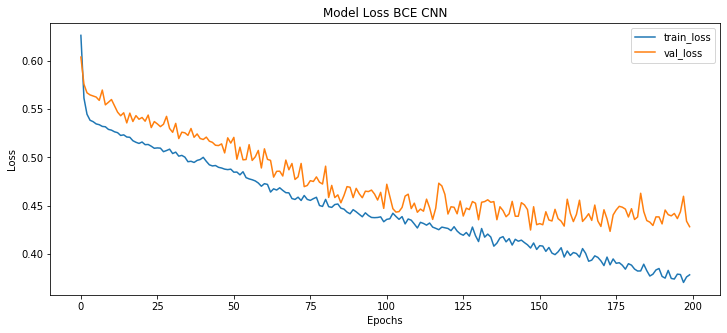

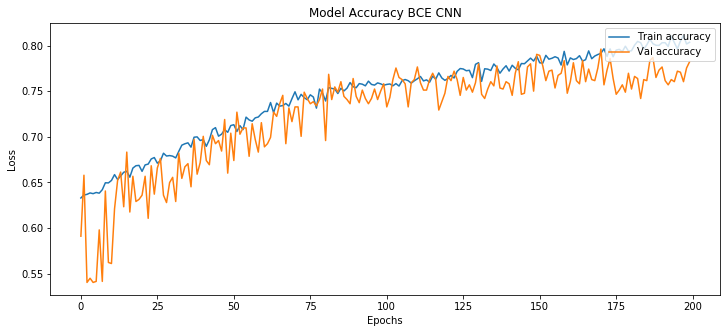

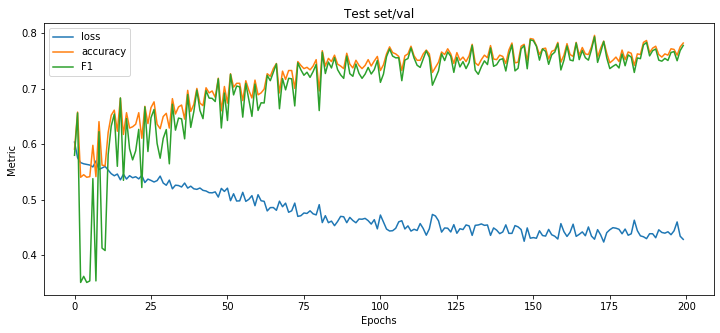

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.860617,0.737771,0.794473,0.756819,0.740658,0.751825
Confirmed,0.614841,0.777943,0.686842,0.756819,0.740658,0.751825


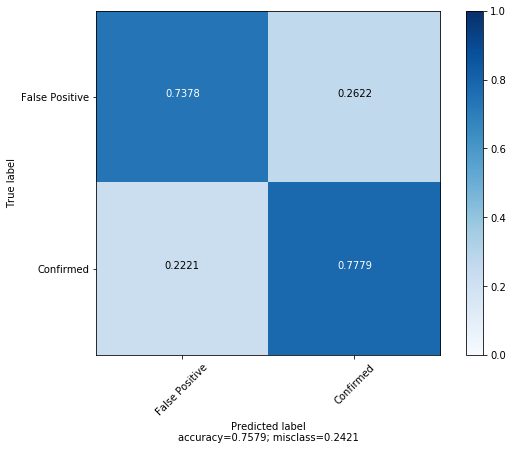

In [42]:
execute_main(n_up,n_down)

In [43]:
n_up = 64
n_down = 64

Objetos de entrenamiento: (8678, 128, 128, 2) (8678,)
Objetos de validación: (1918, 128, 128, 2) (1918,)
Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_27 (Conv2D)           (None, 126, 126, 32)      608       
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_40 (Dropout)         (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 61, 61, 32)        9248      
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 30, 30, 32)        0         
_________________________________________________________________
dropout_41 (Dropout)         (None, 30, 30, 32)        0         
______________

7810/7810 [==============================] - 5s 614us/step - loss: 0.4941 - acc: 0.7024 - val_loss: 0.5282 - val_acc: 0.6394
 - val_f1: 0.582271 
Epoch 42/200
7810/7810 [==============================] - 5s 608us/step - loss: 0.4913 - acc: 0.7050 - val_loss: 0.5221 - val_acc: 0.6567
 - val_f1: 0.613544 
Epoch 43/200
7810/7810 [==============================] - 5s 612us/step - loss: 0.4944 - acc: 0.7008 - val_loss: 0.5307 - val_acc: 0.6336
 - val_f1: 0.559551 
Epoch 44/200
7810/7810 [==============================] - 5s 612us/step - loss: 0.4972 - acc: 0.6942 - val_loss: 0.5237 - val_acc: 0.6578
 - val_f1: 0.613151 
Epoch 45/200
7810/7810 [==============================] - 5s 609us/step - loss: 0.4952 - acc: 0.6909 - val_loss: 0.5151 - val_acc: 0.6889
 - val_f1: 0.688404 
Epoch 46/200
7810/7810 [==============================] - 5s 612us/step - loss: 0.4924 - acc: 0.6891 - val_loss: 0.5161 - val_acc: 0.6912
 - val_f1: 0.660294 
Epoch 47/200
7810/7810 [==============================] - 5

 - val_f1: 0.733640 
Epoch 93/200
7810/7810 [==============================] - 5s 611us/step - loss: 0.4489 - acc: 0.7506 - val_loss: 0.4720 - val_acc: 0.7454
 - val_f1: 0.730965 
Epoch 94/200
7810/7810 [==============================] - 5s 608us/step - loss: 0.4483 - acc: 0.7590 - val_loss: 0.4796 - val_acc: 0.7224
 - val_f1: 0.703840 
Epoch 95/200
7810/7810 [==============================] - 5s 613us/step - loss: 0.4439 - acc: 0.7528 - val_loss: 0.4729 - val_acc: 0.7385
 - val_f1: 0.727133 
Epoch 96/200
7810/7810 [==============================] - 5s 610us/step - loss: 0.4430 - acc: 0.7552 - val_loss: 0.4632 - val_acc: 0.7454
 - val_f1: 0.742926 
Epoch 97/200
7810/7810 [==============================] - 5s 612us/step - loss: 0.4525 - acc: 0.7480 - val_loss: 0.4945 - val_acc: 0.7085
 - val_f1: 0.677045 
Epoch 98/200
7810/7810 [==============================] - 5s 609us/step - loss: 0.4438 - acc: 0.7629 - val_loss: 0.4662 - val_acc: 0.7488
 - val_f1: 0.748313 
Epoch 99/200
7810/7810 [=

7810/7810 [==============================] - 5s 609us/step - loss: 0.3886 - acc: 0.7980 - val_loss: 0.4648 - val_acc: 0.7477
 - val_f1: 0.740036 
Epoch 145/200
7810/7810 [==============================] - 5s 611us/step - loss: 0.3915 - acc: 0.7983 - val_loss: 0.4617 - val_acc: 0.7488
 - val_f1: 0.743265 
Epoch 146/200
7810/7810 [==============================] - 5s 611us/step - loss: 0.3881 - acc: 0.8013 - val_loss: 0.4524 - val_acc: 0.7627
 - val_f1: 0.757564 
Epoch 147/200
7810/7810 [==============================] - 5s 609us/step - loss: 0.3895 - acc: 0.7972 - val_loss: 0.4417 - val_acc: 0.7650
 - val_f1: 0.763923 
Epoch 148/200
7810/7810 [==============================] - 5s 611us/step - loss: 0.3817 - acc: 0.8029 - val_loss: 0.4864 - val_acc: 0.7419
 - val_f1: 0.729515 
Epoch 149/200
7810/7810 [==============================] - 5s 608us/step - loss: 0.3881 - acc: 0.8036 - val_loss: 0.4561 - val_acc: 0.7615
 - val_f1: 0.758870 
Epoch 150/200
7810/7810 [=============================

7810/7810 [==============================] - 5s 608us/step - loss: 0.3001 - acc: 0.8606 - val_loss: 0.4788 - val_acc: 0.7477
 - val_f1: 0.744370 
Epoch 196/200
7810/7810 [==============================] - 5s 608us/step - loss: 0.3024 - acc: 0.8618 - val_loss: 0.5145 - val_acc: 0.7477
 - val_f1: 0.740858 
Epoch 197/200
7810/7810 [==============================] - 5s 609us/step - loss: 0.2908 - acc: 0.8676 - val_loss: 0.4925 - val_acc: 0.7477
 - val_f1: 0.743188 
Epoch 198/200
7810/7810 [==============================] - 5s 608us/step - loss: 0.2965 - acc: 0.8620 - val_loss: 0.5173 - val_acc: 0.7385
 - val_f1: 0.731798 
Epoch 199/200
7810/7810 [==============================] - 5s 608us/step - loss: 0.2992 - acc: 0.8620 - val_loss: 0.4900 - val_acc: 0.7546
 - val_f1: 0.750677 
Epoch 200/200
7810/7810 [==============================] - 5s 609us/step - loss: 0.2980 - acc: 0.8618 - val_loss: 0.5295 - val_acc: 0.7442
 - val_f1: 0.734771 


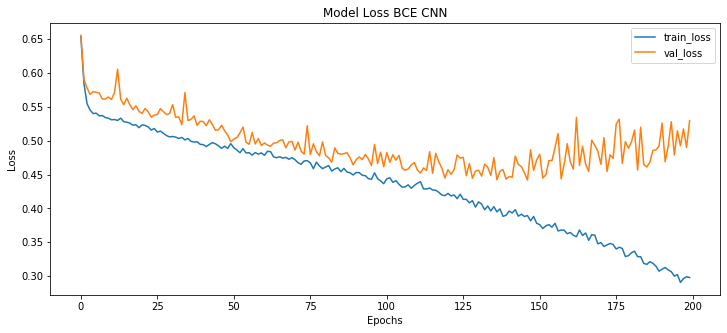

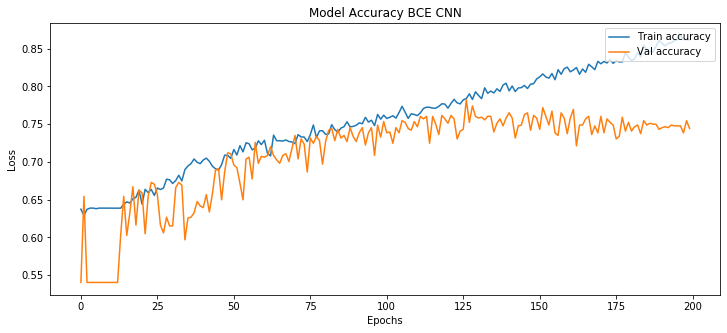

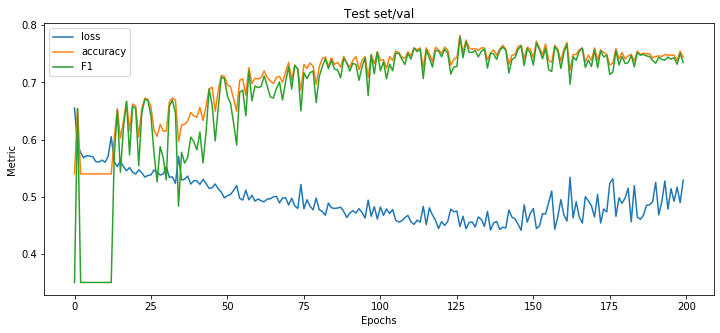

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.860878,0.739374,0.795513,0.757812,0.74163,0.752868
Confirmed,0.616293,0.777943,0.687747,0.757812,0.74163,0.752868


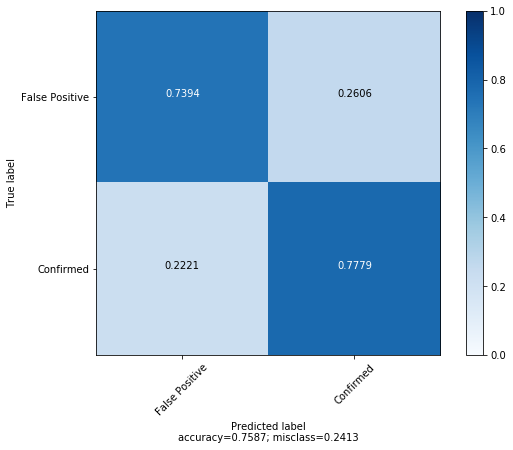

In [44]:
execute_main(n_up,n_down)